# Signate開始時のお約束

In [60]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [61]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'signate.json'", fields="files(id)").execute()
signate_api_key = results.get('files', [])

filename = "/root/.signate/signate.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=signate_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [62]:
!pip install signate

In [63]:
!signate files --competition-id=1523

  fileId  name               title                     size  updated_at
--------  -----------------  ----------------------  ------  -------------------
    3939  train.csv          学習用データ            494008  2024-08-01 12:00:28
    3940  test.csv           評価用データ            488363  2024-08-01 12:00:38
    3944  sample_submit.csv  応募用サンプルファイル   86893  2024-08-01 12:00:49
    4057  tutorial.ipynb     チュートリアルコード    323126  2024-08-01 12:01:00


In [64]:
!signate download --competition-id=1523

sample_submit.csv

tutorial.ipynb

test.csv

train.csv


Download completed.


In [65]:
!pip install kanjize

In [66]:
# ライブラリのインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# データフレーム読み込み
train_df = pd.read_csv("/content/train.csv")
test_df = pd.read_csv("/content/test.csv")

In [67]:
# データ結合(番号を振り直す)
all_df = pd.concat([train_df,test_df],axis=0,ignore_index=True)
max_row = len(all_df)

In [68]:
###############
# "Age"の処理 #
###############
import unicodedata # 全角を半角に変換
from kanjize import kanji2number # 漢字を数値に変換
import re

# 漢字の判定用
p = re.compile('[一二三四五六七八九十]+')

# nanを-1歳で補完
all_df["Age"] = all_df["Age"].fillna("-1歳")

# Ageの処理
for i in range(max_row):

  # 末尾文字の取得
  tail = all_df.loc[i,"Age"][-1:]

  # 先頭文字が漢字の場合
  if(p.search(all_df.loc[i,"Age"][0])!=None):
    tmp = all_df.loc[i,"Age"][:-1]
    all_df.loc[i,"Age"] = kanji2number(tmp)
    all_df.loc[i,"Age"] = int(all_df.loc[i,"Age"])

  # 末尾文字が歳、才、際の場合
  elif((tail=="歳")or(tail=="才")or(tail=="際")):
    all_df.loc[i,"Age"] = all_df.loc[i,"Age"][:-1]
    # 全角を半角に直す
    all_df.loc[i,"Age"] = unicodedata.normalize("NFKC", all_df.loc[i,"Age"])
    all_df.loc[i,"Age"] = int(all_df.loc[i,"Age"])

  # 代の場合
  elif(tail == "代"):
    tmp = all_df.loc[i,"Age"][:-1]
    # 数値変換し5足す
    tmp = int(tmp)
    all_df.loc[i,"Age"] = tmp + 5
    all_df.loc[i,"Age"] = int(all_df.loc[i,"Age"])

# 「-1」はそれ以外の中央値を代入
all_df["Age"] = all_df["Age"].replace(-1,all_df.loc[all_df["Age"]>0,"Age"].median())

# int型にキャストする
all_df["Age"] = all_df["Age"].astype(int)

<ipython-input-68-766871c38253>:42: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  all_df["Age"] = all_df["Age"].replace(-1,all_df.loc[all_df["Age"]>0,"Age"].median())


<Axes: >

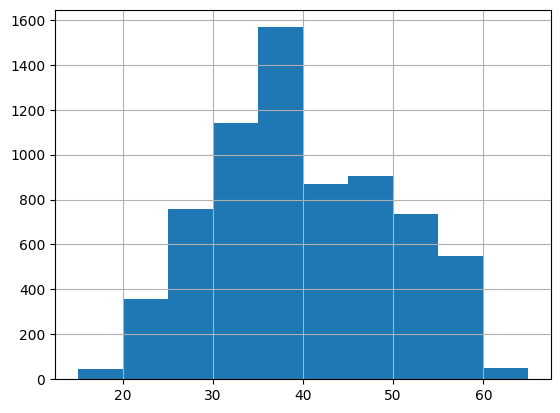

In [69]:
all_df["Age"].hist()

In [70]:
#########################
# "TypeofContact"の処理 #
#########################
# 欠損を埋める
all_df["TypeofContact"] = all_df["TypeofContact"].fillna("Self Enquiry")

In [71]:
# 分類の確認
all_df["TypeofContact"].value_counts()

,count
TypeofContact,
Self Enquiry,4462
Company Invited,2516


In [72]:
#########################
# "CityTier"の処理 #
#########################
# 分類の確認
all_df["CityTier"].value_counts()
# all_df["CityTier"].isnull().sum()

,count
CityTier,
2,3160
1,2991
3,827


In [73]:
#########################
# "DurationOfPitch"の処理 #
#########################
# nanを-1分で補完
all_df["DurationOfPitch"] = all_df["DurationOfPitch"].fillna("-1分")

# 秒を分に変換 #
for i in range(max_row):

  tail = str(all_df.loc[i,"DurationOfPitch"])[-1:]

  if(tail == "秒"):
    tmp = all_df.loc[i,"DurationOfPitch"][:-1]
    all_df.loc[i,"DurationOfPitch"] = float(tmp) / 60.0
  elif(tail == "分"):
    all_df.loc[i,"DurationOfPitch"] = all_df.loc[i,"DurationOfPitch"][:-1]

all_df["DurationOfPitch"] = all_df["DurationOfPitch"].astype("float64")

# 「-1」はそれ以外の中央値を代入
all_df["DurationOfPitch"] = all_df["DurationOfPitch"].replace(-1,all_df.loc[all_df["DurationOfPitch"]>0,"DurationOfPitch"].median())

<Axes: >

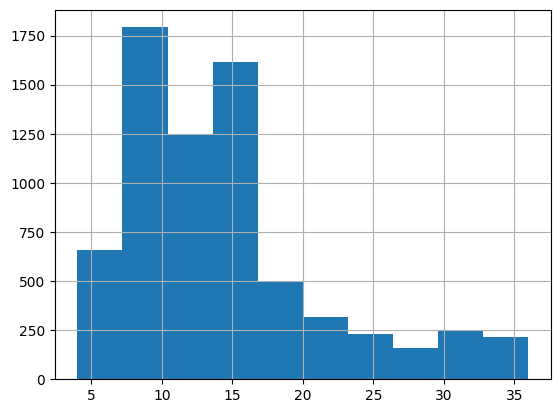

In [74]:
# 分布の確認
all_df["DurationOfPitch"].hist()

In [75]:
####################
# "Occupation"の処理 #
####################
# 個人事業主/会社員/大企業の3択のためホットエンコードにする
all_df["Occupation"].value_counts()
# all_df["Occupation"].isnull().sum()

,count
Occupation,
Small Business,3456
Salaried,2801
Large Business,721


In [76]:
##################
# "Genger"の処理 #
##################
# all_df["Gender"].isnull().sum()
# 先頭文字がMかmならMaleになる
for i in range(max_row):

  # 先頭文字の取得(半角)
  head = unicodedata.normalize("NFKC", all_df.loc[i,"Gender"][:1])

  if(head == "m"):
    all_df.loc[i,"Gender"] = "Male"

  else:
    all_df.loc[i,"Gender"] = "Female"

In [77]:
# 分類の確認
all_df["Gender"].value_counts()

,count
Gender,
Female,5946
Male,1032


In [78]:
##################################
# "NumberOfPersonVisiting"の処理 #
##################################
all_df["NumberOfPersonVisiting"].value_counts()
# all_df["NumberOfPersonVisiting"].isnull().sum()

,count
NumberOfPersonVisiting,
2.0,3163
3.0,2773
1.0,686
4.0,356


In [79]:
##################################
# "NumberOfFollowups"の処理 #
##################################
# all_df["NumberOfFollowups"].value_counts()
# all_df["NumberOfFollowups"].isnull().sum()
all_df["NumberOfFollowups"] = all_df["NumberOfFollowups"].fillna(-1)
all_df["NumberOfFollowups"] = all_df["NumberOfFollowups"].replace(-1,all_df.loc[all_df["NumberOfFollowups"]>0,"NumberOfFollowups"].median())

In [80]:
# 100回以上は記録違いとして100で割る
all_df.loc[all_df["NumberOfFollowups"]>=100,"NumberOfFollowups"] = all_df.loc[all_df["NumberOfFollowups"]>=100,"NumberOfFollowups"] / 100

In [81]:
# 分布の確認
all_df["NumberOfFollowups"].value_counts()

,count
NumberOfFollowups,
4.0,2834
3.0,2561
5.0,1122
2.0,213
1.0,178
6.0,70


In [82]:
##########################
# "ProductPitched"の処理 #
##########################
# ind_name = all_df["ProductPitched"].value_counts().index.values
# all_df["ProductPitched"].isnull().sum()

In [83]:
# ギリシャ文字をアルファベットに変換
greek_string = "αβγδεζηθικλμνξοπρστυφχψωвꓢѕꭰտᗞı𐊡"
alphabet_string = "abgdezhqiklmnxoprstufcywbssdsdib"

def greek_to_alphabet(text):
    result = ""
    for char in text:
        if char in greek_string:
            result += alphabet_string[greek_string.index(char)]
        else:
            result += char  # ギリシャ文字以外の文字はそのまま
    return result

In [84]:
# Basic, Standard, Deluxe, Super Deluxe, kingに分ける
prefix = 0
others = []
# すべて小文字に変換し判定
for i in range(len(all_df)):
  prefix = unicodedata.normalize("NFKC", greek_to_alphabet(all_df.loc[i,"ProductPitched"][:2].lower())).lower()

  if(prefix == "ba"):
    all_df.loc[i,"ProductPitched"] = "Basic"
    # all_df.loc[i,"ProductPitched"] = 1

  elif(prefix == "st"):
    all_df.loc[i,"ProductPitched"] = "Standard"
    # all_df.loc[i,"ProductPitched"] = 2

  elif(prefix == "de"):
    all_df.loc[i,"ProductPitched"] = "Deluxe"
    # all_df.loc[i,"ProductPitched"] = 3

  elif(prefix == "su"):
    all_df.loc[i,"ProductPitched"] = "SuperDeluxe"
    # all_df.loc[i,"ProductPitched"] = 4

  elif(prefix == "ki"):
    all_df.loc[i,"ProductPitched"] = "King"
    # all_df.loc[i,"ProductPitched"] = 5

  else:
    others.append(i)

In [85]:
# 分布の確認
all_df["ProductPitched"].value_counts()

,count
ProductPitched,
Basic,2347
Deluxe,2091
Standard,1614
SuperDeluxe,640
King,286


In [86]:
#################################
# "PreferredPropertyStar"の処理 #
#################################
# all_df["PreferredPropertyStar"].isnull().sum()

# 2引いて揃える
# all_df["PreferredPropertyStar"] = all_df["PreferredPropertyStar"] - 2

all_df["PreferredPropertyStar"].value_counts()

,count
PreferredPropertyStar,
3.0,4328
4.0,2254
5.0,396


In [87]:
#########################
# "NumberOfTrips"の処理 #
#########################
# nanは-1で補完
all_df["NumberOfTrips"] = all_df["NumberOfTrips"].fillna("-1")

# 一旦オブジェクト型に変更
all_df["NumberOfTrips"] = all_df["NumberOfTrips"].astype("object")

for i in range(max_row):

  # 先頭文字の取得(半角)
  head = all_df.loc[i,"NumberOfTrips"][:1]

  if(head == "年"):
    all_df.loc[i,"NumberOfTrips"] = all_df.loc[i,"NumberOfTrips"][2:3]

  elif(head == "半"):
    all_df.loc[i,"NumberOfTrips"] = all_df.loc[i,"NumberOfTrips"][3:4]

  elif(head == "四"):
    all_df.loc[i,"NumberOfTrips"] = all_df.loc[i,"NumberOfTrips"][4:5]

# int型に変更
all_df["NumberOfTrips"] = all_df["NumberOfTrips"].astype("int")

# 「-1」はそれ以外の中央値を代入
all_df["NumberOfTrips"] = all_df["NumberOfTrips"].replace(-1,all_df.loc[all_df["NumberOfTrips"]>0,"NumberOfTrips"].median())

<Axes: >

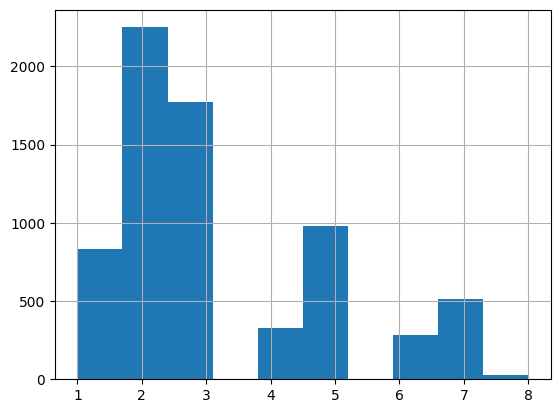

In [88]:
# ヒストグラムの確認
all_df["NumberOfTrips"].hist()

In [89]:
#########################
# "Passport"の処理 #
#########################
# all_df["Passport"].isnull().sum()
all_df["Passport"].value_counts()

,count
Passport,
0,6288
1,690


<Axes: >

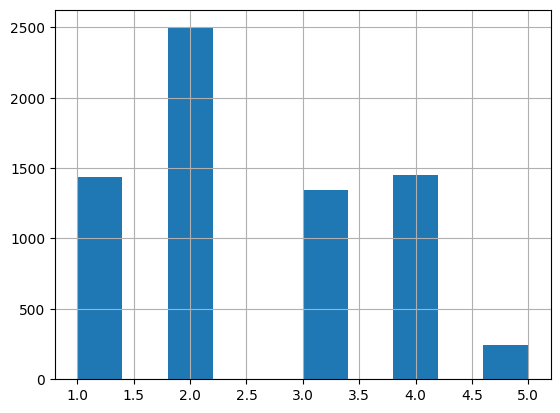

In [90]:
##################################
# "PitchSatisfactionScore"の処理 #
##################################
# all_df["PitchSatisfactionScore"].isnull().sum()
# all_df["PitchSatisfactionScore"].value_counts()
all_df["PitchSatisfactionScore"].hist()

In [91]:
#########################
# "Designation"の処理 #
#########################
# all_df["Designation"].isnull().sum()
# all_df["Designation"].value_counts()

In [92]:
# Executive: 取締役、執行役員
# VP: 副社長、本部長
# AVP: 副社長補佐
# Senior Manager: 課長、次長
# Manager: 課長
# col = []

# for i in range(max_row):

#   if(all_df.loc[i,"Designation"] not in col):
#     col.append(all_df.loc[i,"Designation"])

In [93]:
# ギリシャ文字をアルファベットに変換
greek_string = "αβγδεζηθικλμνξοπρστυφχψωвꓢѕꭰտᗞı𐊡Аае"
alphabet_string = "abgdezhqiklmnxoprstufcywbssdsdibaae"

def greek_to_alphabet(text):
    result = ""
    for char in text:
        if char in greek_string:
            result += alphabet_string[greek_string.index(char)]
        else:
            result += char  # ギリシャ文字以外の文字はそのまま
    return result

In [94]:
# 文字を変換する
prefix = 0
for i in range(len(all_df)):
  prefix = unicodedata.normalize("NFKC", greek_to_alphabet(all_df.loc[i,"Designation"][:1].lower())).lower()

  # Executive: 取締役、執行役員
  if(prefix == "e"):
    all_df.loc[i,"Designation"] = "Executive"
    # all_df.loc[i,"Designation"] = 5

  # Vice President: 本部長
  elif(prefix == "v"):
    all_df.loc[i,"Designation"] = "VP"
    # all_df.loc[i,"Designation"] = 4

  # Associate Vice President: 本部長補佐
  elif(prefix == "a"):
    all_df.loc[i,"Designation"] = "AVP"
    # all_df.loc[i,"Designation"] = 3

  # Senior Manager: 次長
  elif(prefix == "s"):
    all_df.loc[i,"Designation"] = "Senior Manager"
    # all_df.loc[i,"Designation"] = 2

  # Manager: 課長
  elif(prefix == "m"):
    all_df.loc[i,"Designation"] = "Manager"
    # all_df.loc[i,"Designation"] = 1

In [95]:
# 分類の確認
all_df["Designation"].value_counts()

,count
Designation,
Executive,2330
Manager,2117
Senior Manager,1632
AVP,635
VP,264


In [96]:
#########################
# "MonthlyIncome"の処理 #
#########################
import re

# 漢字の判定用
p = re.compile('[月]+')

# nanを-1で補完
all_df["MonthlyIncome"] = all_df["MonthlyIncome"].fillna("-1")

for i in range(max_row):

  # 先頭文字の取得
  head = all_df.loc[i,"MonthlyIncome"][:1]

  # 先頭文字が漢字の場合
  if(p.search(head[0])!=None):
    tmp = all_df.loc[i,"MonthlyIncome"][2:-2]
    all_df.loc[i,"MonthlyIncome"] = float(tmp)*10000

# float型にキャストする
all_df["MonthlyIncome"] = all_df["MonthlyIncome"].astype(float)

# 「-1」はそれ以外の中央値を代入
all_df["MonthlyIncome"] = all_df["MonthlyIncome"].replace(-1,all_df.loc[all_df["MonthlyIncome"]>0,"MonthlyIncome"].median())

<Axes: >

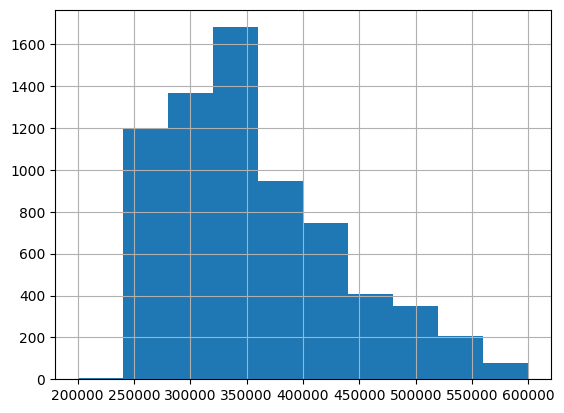

In [97]:
# 分布の確認
all_df["MonthlyIncome"].hist()

In [98]:
#########################
# "customer_info"の処理 #
#########################
import re

# 項目名
cont = []

# 区切り文字で分割する
for i in range(max_row):
  tmp = re.split("[ 　,、\n\t/／\u3000]",all_df.loc[i,"customer_info"])
  tmp = list(filter(None, tmp))
  if(type(tmp)==list):
    for j in range(len(tmp)):
      if(tmp[j] not in cont):
        cont.append(tmp[j])

# キーワード抽出
c_car = [] # 車関係
c_child = [] # 子供関係
c_married = [] # 婚姻関係
c_other = [] # その他

for i in range(len(cont)):
  # 「車あり」、「車所持」、「自家用車あり」、「車保有」、「乗用車所持」、「自動車保有」
  # 「車なし」、「車未所持」、「自家用車なし」、「車保有なし」、「乗用車なし」、「自動車未所有」
  if((cont[i][0:1] == "車") or (cont[i][0:1] == "自") or (cont[i][0:1] == "乗")):
    c_car.append(cont[i])
  # 「こども1人」、「1児」、「子供1人」、「子供有り(1人)」、「子供有り」
  # 「こども2人」、「2児」、「子供2人」、「子供有り(2人)」
  # 「こども3人」、「3児」「子供3人」、「子供有り(3人)」
  # 「子供なし」、「子供無し」、「無子」、「子供ゼロ」、「非児童家庭」
  # 「子育て状況不明」、「子の数不詳」、「子供の数不明」
  elif((cont[i][0:1] == "子") or (cont[i][0:1] == "こ") or (cont[i][-1:] == "児") or (cont[i][-1:] == "子") or (cont[i][-1:] == "庭")):
    c_child.append(cont[i])
  # 「結婚済み」、「離婚済み」、「未婚」、「独身」
  elif((cont[i][0:1] == "結") or (cont[i][0:1] == "離") or (cont[i][0:1] == "独") or (cont[i][0:1] == "離") or (cont[i][0:1] == "未")):
    c_married.append(cont[i])
  # 「1人」、「2人」、「3人」、「不明」、「わからない」
  else:
    c_other.append(cont[i])

In [99]:
# 新たなカラムを追加
all_df["CarHolder"] = 0 # 車所有
all_df["NumofChild"] = 0 # 子供の数
all_df["Married"] = "Single" # 婚姻歴

# 車
c_car_hold = ["車あり","車所持","自家用車あり","車保有","乗用車所持","自動車保有"]

# 子供
c_child_1 = ["こども1人","1児""子供1人","子供有り(1人)","子供有り"]
c_child_2 = ["こども2人","2児""子供2人","子供有り(2人)"]
c_child_3 = ["こども3人","3児""子供3人","子供有り(3人)"]

# 婚姻状況
c_pair = ["結婚済み"]
c_batu = ["離婚済み"]

# 区切り文字で分割する
for i in range(max_row):
  tmp = re.split("[ 　,、\n\t/／\u3000]",all_df.loc[i,"customer_info"])
  tmp = list(filter(None, tmp))
  if(type(tmp)==list):
    for j in range(len(tmp)):
      # 車の情報
      if(tmp[j] in c_car_hold):
        all_df.loc[i, "CarHolder"] = 1
      # 子供の情報
      if(tmp[j] in c_child_1):
        all_df.loc[i, "NumofChild"] = 1
      if(tmp[j] in c_child_2):
        all_df.loc[i, "NumofChild"] = 2
      if(tmp[j] in c_child_3):
        all_df.loc[i, "NumofChild"] = 3
      # 婚姻歴
      if(tmp[j] in c_pair):
        all_df.loc[i, "Married"] = "Married"
      if(tmp[j] in c_batu):
        all_df.loc[i, "Married"] = "Divorce"

# 使用済みカラム抹消
all_df = all_df.drop("customer_info", axis=1)

In [100]:
# 車保有率
all_df["CarHolder"].value_counts()

,count
CarHolder,
0,4408
1,2570


In [101]:
# 子供の数
all_df["NumofChild"].value_counts()

,count
NumofChild,
0,5015
1,1347
2,571
3,45


In [102]:
# 婚姻歴
all_df["Married"].value_counts()

,count
Married,
Married,2846
Single,2444
Divorce,1688


In [103]:
# # 子供の数ごとに成約率の平均を加える

# # 成約率平均
# child0 = all_df.loc[all_df["NumofChild"]==0,"ProdTaken"].mean()
# child1 = all_df.loc[all_df["NumofChild"]==1,"ProdTaken"].mean()
# child2 = all_df.loc[all_df["NumofChild"]==2,"ProdTaken"].mean()
# child3 = all_df.loc[all_df["NumofChild"]>=3,"ProdTaken"].mean()

# # 特徴量を加える
# all_df["AveProdTaken_numChild"] = 0

# all_df.loc[all_df["NumofChild"]==0,"AveProdTaken_numChild"] = child0
# all_df.loc[all_df["NumofChild"]==1,"AveProdTaken_numChild"] = child1
# all_df.loc[all_df["NumofChild"]==2,"AveProdTaken_numChild"] = child2
# all_df.loc[all_df["NumofChild"]==3,"AveProdTaken_numChild"] = child3

In [104]:
# all_df["AveProdTaken_numChild"]

In [105]:
# 取り除く変数
RMV = ["id","ProdTaken"]

# 使用する変数を制限
FEATURES = ["Age","TypeofContact","CityTier","DurationOfPitch","Occupation","Gender","NumberOfPersonVisiting","NumberOfFollowups","ProductPitched",
            "PreferredPropertyStar","NumberOfTrips","Passport","PitchSatisfactionScore","MonthlyIncome","CarHolder","Married","NumofChild","Designation",
            "ProdTaken"]
            # "ProdTaken","AveProdTaken_numChild"]

TARGET = "ProdTaken"

In [106]:
CATS = []
for c in FEATURES:
  if all_df[c].dtype == "object":
    CATS.append(c)

In [107]:
# カラムを制限
all_df2 = all_df[FEATURES]
all_df2 = pd.get_dummies(all_df2, columns=CATS)

In [108]:
# 結合を戻す
train = all_df2.iloc[:len(train_df)].copy()
test = all_df2.iloc[len(train_df):].reset_index(drop=True).copy()

In [109]:
# 対象の列のみ取り込み
test = test.drop(TARGET,axis=1)

In [110]:
FEATURES = test.columns

In [111]:
# import optuna
import lightgbm as lgb
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import KFold # K分割
# from xgboost import XGBRegressor, XGBClassifier
# import xgboost
import lightgbm as lgb
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.metrics import mean_squared_error

lgbm_params = {
    'objective': 'regression',
    # "device": "cuda",
    "device": "cpu",
    'metric': 'rmse',
    'boosting_type': 'gbdt',    # BoostingのType
    'num_leaves': 63,           # 葉の数　default = 31,
    'learning_rate': 0.01,       # 学習率　default = 0.1
    'feature_fraction': 0.8,    # 特徴量側のサンプリング　default = 1.0
    'bagging_freq': 5,          # Baggingを何回に1回行うか　default = 0
    'bagging_fraction': 0.8,    # サンプル側のサンプリング　default = 1.0
    # 'num_boost_round': 6000,
    'random_state': 42,
    # 'max_depth': -1,          # 木の深さ（デフォルトは無制限）
    'verbose': -1              # ログ出力の制御
    }

In [112]:
%%time

FOLDS = 3 # 分割数
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_lgb = np.zeros(len(train))
pred_lgb = np.zeros(len(test))
models = []
evaluations_result = {}

for i, (train_index, test_index) in enumerate(kf.split(train)):

  print("#"*25)
  print(f"### Fold {i+1}")
  print("#"*25)

  # インデックスに割り振る

  x_train = train.loc[train_index, FEATURES].copy()
  y_train = train.loc[train_index, TARGET]
  x_valid = train.loc[test_index, FEATURES].copy()
  y_valid = train.loc[test_index, TARGET]
  # x_test = test[FEATURES].copy()

  # データセット作成
  lgb_train = lgb.Dataset(x_train, y_train)
  lgb_eval = lgb.Dataset(x_valid, y_valid, reference = lgb_train)

  # 学習
  model_lgb = lgb.train(lgbm_params,
                        lgb_train,
                        num_boost_round = 2000,
                        valid_sets = [lgb_train, lgb_eval],
                        valid_names = ["train", "valid"],
                        callbacks = [
                            lgb.early_stopping(stopping_rounds=100, verbose=False),
                            lgb.record_evaluation(evaluations_result),
                            lgb.log_evaluation(100),])


  # y_pred = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)

  oof_lgb[test_index] = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)
  models.append(model_lgb)
  # pred_lgb += model_lgb.predict(x_test, num_iteration = model_lgb.best_iteration)

# pred_lgb = []
# # 予測
# for model in models:
#   pred_lgb.append(model.predict(x_test, num_iteration = model.best_iteration))

# pred_lgb = np.mean(np.expm1(pred_lgb), axis=0)

pred_lgb /= FOLDS

#########################
### Fold 1
#########################
[100]	train's rmse: 0.291334	valid's rmse: 0.309362
[200]	train's rmse: 0.26333	valid's rmse: 0.30393
[300]	train's rmse: 0.24265	valid's rmse: 0.303799
#########################
### Fold 2
#########################
[100]	train's rmse: 0.280203	valid's rmse: 0.330769
[200]	train's rmse: 0.252825	valid's rmse: 0.327317
#########################
### Fold 3
#########################
[100]	train's rmse: 0.295452	valid's rmse: 0.301871
[200]	train's rmse: 0.266857	valid's rmse: 0.296899
CPU times: user 12.5 s, sys: 105 ms, total: 12.6 s
Wall time: 1.61 s


In [113]:
from sklearn.metrics import roc_auc_score # AUC評価指標
# AUCの評価(第一引数にy_trueを入れる)
score = roc_auc_score(train[TARGET],oof_lgb)
print(score)

0.8149754139812134


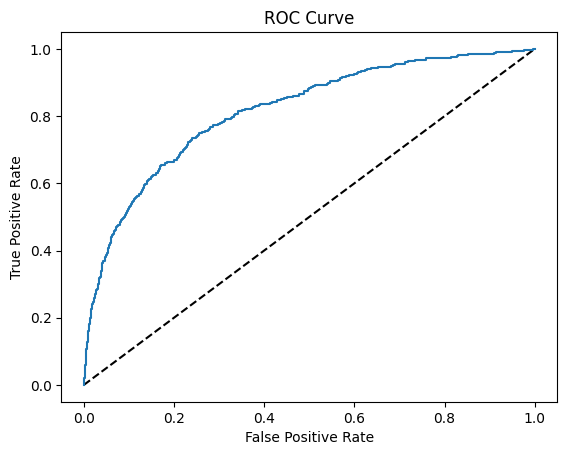

In [114]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(train[TARGET],oof_lgb)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr,tpr,label='LogisticRegression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [115]:
!pip install optuna

In [122]:
# Optunaを使用する
import optuna
import lightgbm as lgb
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import KFold # K分割
import lightgbm as lgb
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.metrics import mean_squared_error

def objective(trial):

  lgbm_params = {
      'objective': 'regression',
      "device": "cpu",
      'metric': 'rmse',
      'verbose': -1,              # ログ出力の制御
      'boosting_type': 'gbdt',
      'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
      'num_leaves': trial.suggest_int('num_leaves', 2, 256), # 20回
      'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1),
      # 'bagging_freq': trial.suggest_uniform('bagging_freq', 1, 7),
      'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1), # 2回目
      'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0),
      'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0),
      'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 100),
      # 'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),
      # 'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
      # 'max_depth': trial.suggest_int('max_depth', 3, 12),
      }

  FOLDS = 3 # 分割数
  kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

  oof_lgb = np.zeros(len(train))
  pred_lgb = np.zeros(len(test))
  models = []
  evaluations_result = {}

  for i, (train_index, test_index) in enumerate(kf.split(train)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

    # インデックスに割り振る

    x_train = train.loc[train_index, FEATURES].copy()
    y_train = train.loc[train_index, TARGET]
    x_valid = train.loc[test_index, FEATURES].copy()
    y_valid = train.loc[test_index, TARGET]
    # x_test = test[FEATURES].copy()

    # データセット作成
    lgb_train = lgb.Dataset(x_train, y_train)
    lgb_eval = lgb.Dataset(x_valid, y_valid, reference = lgb_train)

    # 学習
    model_lgb = lgb.train(lgbm_params,
                          lgb_train,
                          num_boost_round = 2000,
                          valid_sets = [lgb_train, lgb_eval],
                          valid_names = ["train", "valid"],
                          callbacks = [
                              lgb.early_stopping(stopping_rounds=100, verbose=False),
                              # lgb.record_evaluation(evaluations_result),
                              lgb.log_evaluation(100),])


    # y_pred = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)

    oof_lgb[test_index] = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)
    # models.append(model_lgb)
    # pred_lgb += model_lgb.predict(x_test, num_iteration = model_lgb.best_iteration)

  # pred_lgb = []
  # # 予測
  # for model in models:
  #   pred_lgb.append(model.predict(x_test, num_iteration = model.best_iteration))

  # pred_lgb = np.mean(np.expm1(pred_lgb), axis=0)

  # pred_lgb /= FOLDS
  # score = roc_auc_score(train[TARGET],oof_lgb)

  mse = mean_squared_error(train[TARGET], oof_lgb)
  rmse = np.sqrt(mse)  # MSEの平方根を取ってRMSEを計算

  return rmse

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

[I 2025-05-18 08:48:36,078] A new study created in memory with name: no-name-73d1c171-d256-4143-aead-780a8f25e053
<ipython-input-122-2a4188c4dd36>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's rmse: 0.27048	valid's rmse: 0.304113
#########################
### Fold 2
#########################
[100]	train's rmse: 0.260341	valid's rmse: 0.327353


[I 2025-05-18 08:48:36,461] Trial 0 finished with value: 0.3076419506248332 and parameters: {'feature_fraction': 0.6819451704814314, 'num_leaves': 68, 'bagging_fraction': 0.6694907335131949, 'lambda_l1': 2.0664527743218173, 'lambda_l2': 4.407875416337386, 'min_data_in_leaf': 62}. Best is trial 0 with value: 0.3076419506248332.


#########################
### Fold 3
#########################
[100]	train's rmse: 0.270416	valid's rmse: 0.297964
#########################
### Fold 1
#########################


<ipython-input-122-2a4188c4dd36>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's rmse: 0.276383	valid's rmse: 0.305379
#########################
### Fold 2
#########################
[100]	train's rmse: 0.266843	valid's rmse: 0.327645
#########################
### Fold 3
#########################


[I 2025-05-18 08:48:36,781] Trial 1 finished with value: 0.30854278889040027 and parameters: {'feature_fraction': 0.5790992625875052, 'num_leaves': 168, 'bagging_fraction': 0.8723244163630471, 'lambda_l1': 1.4380687693106697, 'lambda_l2': 5.570684932291558, 'min_data_in_leaf': 84}. Best is trial 0 with value: 0.3076419506248332.


[100]	train's rmse: 0.276889	valid's rmse: 0.29745
#########################
### Fold 1
#########################
[100]	train's rmse: 0.277086	valid's rmse: 0.302991
#########################
### Fold 2
#########################
[100]	train's rmse: 0.266654	valid's rmse: 0.326782


<ipython-input-122-2a4188c4dd36>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
[I 2025-05-18 08:48:37,057] Trial 2 finished with value: 0.30663434965603625 and parameters: {'feature_fraction': 0.738243217241444, 'num_leaves': 68, 'bagging_fraction': 0.47231186911394235, 'lambda_l1': 3.03812841026023, 'lambda_l2': 4.269289338688074, 'min_data_in_leaf': 66}. Best is trial 2 with value: 0.30663434965603625.


#########################
### Fold 3
#########################
[100]	train's rmse: 0.278487	valid's rmse: 0.294812
#########################
### Fold 1
#########################
[100]	train's rmse: 0.312486	valid's rmse: 0.307373
[200]	train's rmse: 0.309893	valid's rmse: 0.305306
[300]	train's rmse: 0.308917	valid's rmse: 0.304697
[400]	train's rmse: 0.308448	valid's rmse: 0.304421
[500]	train's rmse: 0.308194	valid's rmse: 0.30428
[600]	train's rmse: 0.308041	valid's rmse: 0.304244


<ipython-input-122-2a4188c4dd36>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[700]	train's rmse: 0.307934	valid's rmse: 0.304227
[800]	train's rmse: 0.307857	valid's rmse: 0.30422
[900]	train's rmse: 0.307795	valid's rmse: 0.304216
[1000]	train's rmse: 0.307746	valid's rmse: 0.30421
[1100]	train's rmse: 0.307705	valid's rmse: 0.304205
[1200]	train's rmse: 0.307672	valid's rmse: 0.304204
[1300]	train's rmse: 0.307645	valid's rmse: 0.304201
[1400]	train's rmse: 0.307623	valid's rmse: 0.304202
[1500]	train's rmse: 0.307605	valid's rmse: 0.3042
#########################
### Fold 2
#########################
[100]	train's rmse: 0.300687	valid's rmse: 0.330403
[200]	train's rmse: 0.297949	valid's rmse: 0.328473
[300]	train's rmse: 0.297076	valid's rmse: 0.327978
[400]	train's rmse: 0.296676	valid's rmse: 0.327725
[500]	train's rmse: 0.296456	valid's rmse: 0.327614
[600]	train's rmse: 0.296306	valid's rmse: 0.327544
[700]	train's rmse: 0.296196	valid's rmse: 0.327497
[800]	train's rmse: 0.296115	valid's rmse: 0.327453
[900]	train's rmse: 0.296055	valid's rmse: 0.327424

[I 2025-05-18 08:48:38,002] Trial 3 finished with value: 0.30992236534244083 and parameters: {'feature_fraction': 0.9243274094497785, 'num_leaves': 2, 'bagging_fraction': 0.6116524458552732, 'lambda_l1': 4.525806027684821, 'lambda_l2': 7.886510877010744, 'min_data_in_leaf': 52}. Best is trial 2 with value: 0.30663434965603625.


#########################
### Fold 3
#########################
[100]	train's rmse: 0.31545	valid's rmse: 0.299026
[200]	train's rmse: 0.312435	valid's rmse: 0.297706
[300]	train's rmse: 0.311237	valid's rmse: 0.297499
[400]	train's rmse: 0.310591	valid's rmse: 0.297473
#########################
### Fold 1
#########################


<ipython-input-122-2a4188c4dd36>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's rmse: 0.295763	valid's rmse: 0.301435
#########################
### Fold 2
#########################
[100]	train's rmse: 0.283727	valid's rmse: 0.326354
#########################
### Fold 3
#########################


[I 2025-05-18 08:48:38,983] Trial 4 finished with value: 0.3071995291457489 and parameters: {'feature_fraction': 0.7006113628371575, 'num_leaves': 118, 'bagging_fraction': 0.8179415864290203, 'lambda_l1': 9.535567344376759, 'lambda_l2': 6.244693406552452, 'min_data_in_leaf': 8}. Best is trial 2 with value: 0.30663434965603625.


[100]	train's rmse: 0.297331	valid's rmse: 0.292853
#########################
### Fold 1
#########################


<ipython-input-122-2a4188c4dd36>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's rmse: 0.213144	valid's rmse: 0.312362
#########################
### Fold 2
#########################
[100]	train's rmse: 0.210337	valid's rmse: 0.334299
#########################
### Fold 3
#########################


[I 2025-05-18 08:48:40,824] Trial 5 finished with value: 0.3082435349777979 and parameters: {'feature_fraction': 0.7108418157039977, 'num_leaves': 177, 'bagging_fraction': 0.7451757504569175, 'lambda_l1': 1.2213433181034525, 'lambda_l2': 1.9682293147426062, 'min_data_in_leaf': 21}. Best is trial 2 with value: 0.30663434965603625.


[100]	train's rmse: 0.215321	valid's rmse: 0.305811
#########################
### Fold 1
#########################
[100]	train's rmse: 0.300961	valid's rmse: 0.301556
[200]	train's rmse: 0.300586	valid's rmse: 0.301356


<ipython-input-122-2a4188c4dd36>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 2
#########################
[100]	train's rmse: 0.288448	valid's rmse: 0.326762
[200]	train's rmse: 0.288099	valid's rmse: 0.326487
[300]	train's rmse: 0.288099	valid's rmse: 0.326485
[400]	train's rmse: 0.288099	valid's rmse: 0.326485


[I 2025-05-18 08:48:41,361] Trial 6 finished with value: 0.3076112214694242 and parameters: {'feature_fraction': 0.43177223685561794, 'num_leaves': 252, 'bagging_fraction': 0.9003594107980586, 'lambda_l1': 8.34516184270677, 'lambda_l2': 9.288035316223915, 'min_data_in_leaf': 84}. Best is trial 2 with value: 0.30663434965603625.


[500]	train's rmse: 0.288099	valid's rmse: 0.326485
[600]	train's rmse: 0.288099	valid's rmse: 0.326485
[700]	train's rmse: 0.288099	valid's rmse: 0.326485
#########################
### Fold 3
#########################
[100]	train's rmse: 0.301471	valid's rmse: 0.294165
[200]	train's rmse: 0.301143	valid's rmse: 0.294115
#########################
### Fold 1
#########################


<ipython-input-122-2a4188c4dd36>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's rmse: 0.280026	valid's rmse: 0.303546
#########################
### Fold 2
#########################
[100]	train's rmse: 0.269452	valid's rmse: 0.327147
#########################
### Fold 3
#########################


[I 2025-05-18 08:48:41,790] Trial 7 finished with value: 0.30712403650189257 and parameters: {'feature_fraction': 0.9833019847838036, 'num_leaves': 120, 'bagging_fraction': 0.5789474295845285, 'lambda_l1': 3.930180044944855, 'lambda_l2': 4.775795200446206, 'min_data_in_leaf': 65}. Best is trial 2 with value: 0.30663434965603625.


[100]	train's rmse: 0.281418	valid's rmse: 0.293926
#########################
### Fold 1
#########################
[100]	train's rmse: 0.289695	valid's rmse: 0.300835
#########################
### Fold 2
#########################
[100]	train's rmse: 0.277696	valid's rmse: 0.326453
[200]	train's rmse: 0.277401	valid's rmse: 0.326433
#########################
### Fold 3
#########################


<ipython-input-122-2a4188c4dd36>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
[I 2025-05-18 08:48:42,019] Trial 8 finished with value: 0.30704358907675217 and parameters: {'feature_fraction': 0.6124458049899034, 'num_leaves': 212, 'bagging_fraction': 0.7014671333997955, 'lambda_l1': 5.116007619447518, 'lambda_l2': 5.572780244522823, 'min_data_in_leaf': 55}. Best is trial 2 with value: 0.30663434965603625.


[100]	train's rmse: 0.289493	valid's rmse: 0.293799
#########################
### Fold 1
#########################
[100]	train's rmse: 0.299664	valid's rmse: 0.301987
#########################
### Fold 2
#########################
[100]	train's rmse: 0.286778	valid's rmse: 0.327189
#########################
### Fold 3
#########################
[100]	train's rmse: 0.30169	valid's rmse: 0.294573
[200]	train's rmse: 0.301688	valid's rmse: 0.294571


<ipython-input-122-2a4188c4dd36>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
[I 2025-05-18 08:48:42,245] Trial 9 finished with value: 0.30823185271452586 and parameters: {'feature_fraction': 0.7181526538019627, 'num_leaves': 32, 'bagging_fraction': 0.544055894554295, 'lambda_l1': 8.47645558155189, 'lambda_l2': 4.352995748959986, 'min_data_in_leaf': 95}. Best is trial 2 with value: 0.30663434965603625.


[300]	train's rmse: 0.301688	valid's rmse: 0.294571
[400]	train's rmse: 0.301688	valid's rmse: 0.294571
#########################
### Fold 1
#########################
[100]	train's rmse: 0.289601	valid's rmse: 0.300399
#########################
### Fold 2
#########################
[100]	train's rmse: 0.277562	valid's rmse: 0.326644
#########################
### Fold 3
#########################


<ipython-input-122-2a4188c4dd36>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
[I 2025-05-18 08:48:42,478] Trial 10 finished with value: 0.30666832159266677 and parameters: {'feature_fraction': 0.8451585775421765, 'num_leaves': 75, 'bagging_fraction': 0.4349932901063674, 'lambda_l1': 6.272719439730029, 'lambda_l2': 0.11812483917662142, 'min_data_in_leaf': 36}. Best is trial 2 with value: 0.30663434965603625.


[100]	train's rmse: 0.290032	valid's rmse: 0.292465
#########################
### Fold 1
#########################
[100]	train's rmse: 0.289867	valid's rmse: 0.300804
#########################
### Fold 2
#########################
[100]	train's rmse: 0.279093	valid's rmse: 0.326606
#########################
### Fold 3
#########################


<ipython-input-122-2a4188c4dd36>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
[I 2025-05-18 08:48:42,755] Trial 11 finished with value: 0.3068027031486498 and parameters: {'feature_fraction': 0.8263006973109994, 'num_leaves': 85, 'bagging_fraction': 0.40579687520230273, 'lambda_l1': 6.511380251876432, 'lambda_l2': 0.4413932681940249, 'min_data_in_leaf': 36}. Best is trial 2 with value: 0.30663434965603625.


[100]	train's rmse: 0.291763	valid's rmse: 0.292425
#########################
### Fold 1
#########################
[100]	train's rmse: 0.264312	valid's rmse: 0.305157
#########################
### Fold 2
#########################


<ipython-input-122-2a4188c4dd36>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
[I 2025-05-18 08:48:43,094] Trial 12 finished with value: 0.30681163643907966 and parameters: {'feature_fraction': 0.8395639054575265, 'num_leaves': 68, 'bagging_fraction': 0.40188449134057647, 'lambda_l1': 3.0092117507932743, 'lambda_l2': 2.2485537106398885, 'min_data_in_leaf': 38}. Best is trial 2 with value: 0.30663434965603625.


[100]	train's rmse: 0.25589	valid's rmse: 0.327323
#########################
### Fold 3
#########################
[100]	train's rmse: 0.265132	valid's rmse: 0.298226
#########################
### Fold 1
#########################


<ipython-input-122-2a4188c4dd36>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
[I 2025-05-18 08:48:43,327] Trial 13 finished with value: 0.3070293640025746 and parameters: {'feature_fraction': 0.8267472778769177, 'num_leaves': 37, 'bagging_fraction': 0.49443996968917375, 'lambda_l1': 6.090914294585745, 'lambda_l2': 0.5548174086408055, 'min_data_in_leaf': 35}. Best is trial 2 with value: 0.30663434965603625.


[100]	train's rmse: 0.288308	valid's rmse: 0.301327
#########################
### Fold 2
#########################
[100]	train's rmse: 0.277218	valid's rmse: 0.326559
#########################
### Fold 3
#########################
[100]	train's rmse: 0.289333	valid's rmse: 0.293056
#########################
### Fold 1
#########################


<ipython-input-122-2a4188c4dd36>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
[I 2025-05-18 08:48:43,549] Trial 14 finished with value: 0.30708896730816687 and parameters: {'feature_fraction': 0.8899195787539599, 'num_leaves': 89, 'bagging_fraction': 0.47543938787924844, 'lambda_l1': 6.544289438969043, 'lambda_l2': 2.5442492300220225, 'min_data_in_leaf': 74}. Best is trial 2 with value: 0.30663434965603625.


[100]	train's rmse: 0.293428	valid's rmse: 0.301349
#########################
### Fold 2
#########################
[100]	train's rmse: 0.281678	valid's rmse: 0.326008
#########################
### Fold 3
#########################
[100]	train's rmse: 0.294457	valid's rmse: 0.293185
#########################
### Fold 1
#########################


<ipython-input-122-2a4188c4dd36>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's rmse: 0.275198	valid's rmse: 0.302836
#########################
### Fold 2
#########################
[100]	train's rmse: 0.265109	valid's rmse: 0.327138
#########################
### Fold 3
#########################


[I 2025-05-18 08:48:43,899] Trial 15 finished with value: 0.3060204784920884 and parameters: {'feature_fraction': 0.7812973908211502, 'num_leaves': 146, 'bagging_fraction': 0.4840892476814833, 'lambda_l1': 3.559281563882477, 'lambda_l2': 3.2740034592848213, 'min_data_in_leaf': 47}. Best is trial 15 with value: 0.3060204784920884.


[100]	train's rmse: 0.275413	valid's rmse: 0.29459
#########################
### Fold 1
#########################
[100]	train's rmse: 0.267191	valid's rmse: 0.305292
#########################
### Fold 2
#########################


<ipython-input-122-2a4188c4dd36>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
[I 2025-05-18 08:48:44,298] Trial 16 finished with value: 0.3065442531221517 and parameters: {'feature_fraction': 0.7634098606429824, 'num_leaves': 130, 'bagging_fraction': 0.5081300725695362, 'lambda_l1': 2.6131999289037964, 'lambda_l2': 3.34066911776151, 'min_data_in_leaf': 50}. Best is trial 15 with value: 0.3060204784920884.


[100]	train's rmse: 0.258456	valid's rmse: 0.32816
#########################
### Fold 3
#########################
[100]	train's rmse: 0.269347	valid's rmse: 0.296749
#########################
### Fold 1
#########################


<ipython-input-122-2a4188c4dd36>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's rmse: 0.235939	valid's rmse: 0.307525
#########################
### Fold 2
#########################
[100]	train's rmse: 0.228592	valid's rmse: 0.332412
#########################
### Fold 3
#########################


[I 2025-05-18 08:48:44,713] Trial 17 finished with value: 0.3080355892275694 and parameters: {'feature_fraction': 0.5430183051854236, 'num_leaves': 154, 'bagging_fraction': 0.5446653962202477, 'lambda_l1': 0.18036559210983283, 'lambda_l2': 3.266733786819321, 'min_data_in_leaf': 46}. Best is trial 15 with value: 0.3060204784920884.


[100]	train's rmse: 0.237941	valid's rmse: 0.303482
#########################
### Fold 1
#########################
[100]	train's rmse: 0.258187	valid's rmse: 0.304998


<ipython-input-122-2a4188c4dd36>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 2
#########################
[100]	train's rmse: 0.24957	valid's rmse: 0.329201
#########################
### Fold 3
#########################


[I 2025-05-18 08:48:45,115] Trial 18 finished with value: 0.3076690894065253 and parameters: {'feature_fraction': 0.7594852899822997, 'num_leaves': 204, 'bagging_fraction': 0.6169069860461178, 'lambda_l1': 3.170046756075425, 'lambda_l2': 6.963071424783845, 'min_data_in_leaf': 14}. Best is trial 15 with value: 0.3060204784920884.


[100]	train's rmse: 0.257863	valid's rmse: 0.297317
#########################
### Fold 1
#########################
[100]	train's rmse: 0.175764	valid's rmse: 0.317128


<ipython-input-122-2a4188c4dd36>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 2
#########################
[100]	train's rmse: 0.173244	valid's rmse: 0.337351
#########################
### Fold 3
#########################


[I 2025-05-18 08:48:45,708] Trial 19 finished with value: 0.3091865228552247 and parameters: {'feature_fraction': 0.7891571721697859, 'num_leaves': 141, 'bagging_fraction': 0.9536103467789117, 'lambda_l1': 0.0988618500508891, 'lambda_l2': 3.185232213761237, 'min_data_in_leaf': 26}. Best is trial 15 with value: 0.3060204784920884.


[100]	train's rmse: 0.179631	valid's rmse: 0.311266
#########################
### Fold 1
#########################
[100]	train's rmse: 0.263408	valid's rmse: 0.304461
#########################
### Fold 2
#########################


<ipython-input-122-2a4188c4dd36>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
[I 2025-05-18 08:48:46,095] Trial 20 finished with value: 0.30712440466706664 and parameters: {'feature_fraction': 0.6317008260148465, 'num_leaves': 104, 'bagging_fraction': 0.7645085510187799, 'lambda_l1': 2.1141871598423383, 'lambda_l2': 1.429117130598794, 'min_data_in_leaf': 47}. Best is trial 15 with value: 0.3060204784920884.


[100]	train's rmse: 0.256308	valid's rmse: 0.329339
#########################
### Fold 3
#########################
[100]	train's rmse: 0.264339	valid's rmse: 0.297751
#########################
### Fold 1
#########################


<ipython-input-122-2a4188c4dd36>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's rmse: 0.279613	valid's rmse: 0.303006
#########################
### Fold 2
#########################
[100]	train's rmse: 0.26878	valid's rmse: 0.326916
#########################
### Fold 3
#########################
[100]	train's rmse: 0.281198	valid's rmse: 0.294364


[I 2025-05-18 08:48:46,401] Trial 21 finished with value: 0.3065715362751281 and parameters: {'feature_fraction': 0.7666269171653982, 'num_leaves': 136, 'bagging_fraction': 0.49035771803176487, 'lambda_l1': 3.4666545361911947, 'lambda_l2': 3.6012643729858644, 'min_data_in_leaf': 67}. Best is trial 15 with value: 0.3060204784920884.
<ipython-input-122-2a4188c4dd36>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's rmse: 0.285735	valid's rmse: 0.302437
#########################
### Fold 2
#########################
[100]	train's rmse: 0.27476	valid's rmse: 0.325398
[200]	train's rmse: 0.27413	valid's rmse: 0.325372
#########################
### Fold 3
#########################


[I 2025-05-18 08:48:46,712] Trial 22 finished with value: 0.30704370741637027 and parameters: {'feature_fraction': 0.7786609183082568, 'num_leaves': 191, 'bagging_fraction': 0.5151041999237693, 'lambda_l1': 4.048778698150641, 'lambda_l2': 3.451316115726413, 'min_data_in_leaf': 78}. Best is trial 15 with value: 0.3060204784920884.


[100]	train's rmse: 0.285561	valid's rmse: 0.294723
#########################
### Fold 1
#########################
[100]	train's rmse: 0.287392	valid's rmse: 0.301764
#########################
### Fold 2
#########################
[100]	train's rmse: 0.275859	valid's rmse: 0.326255
#########################
### Fold 3
#########################


<ipython-input-122-2a4188c4dd36>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
[I 2025-05-18 08:48:46,997] Trial 23 finished with value: 0.30689994315073865 and parameters: {'feature_fraction': 0.904629978668097, 'num_leaves': 140, 'bagging_fraction': 0.6458649314059013, 'lambda_l1': 5.362600775510908, 'lambda_l2': 3.7798637374461768, 'min_data_in_leaf': 57}. Best is trial 15 with value: 0.3060204784920884.


[100]	train's rmse: 0.287972	valid's rmse: 0.293797
#########################
### Fold 1
#########################
[100]	train's rmse: 0.281145	valid's rmse: 0.301695
#########################
### Fold 2
#########################
[100]	train's rmse: 0.271814	valid's rmse: 0.326497


<ipython-input-122-2a4188c4dd36>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
[I 2025-05-18 08:48:47,309] Trial 24 finished with value: 0.3067171404298407 and parameters: {'feature_fraction': 0.4863851823978256, 'num_leaves': 153, 'bagging_fraction': 0.5734821472469376, 'lambda_l1': 3.7007166528673703, 'lambda_l2': 1.409667051871276, 'min_data_in_leaf': 45}. Best is trial 15 with value: 0.3060204784920884.


#########################
### Fold 3
#########################
[100]	train's rmse: 0.281345	valid's rmse: 0.294259
#########################
### Fold 1
#########################
[100]	train's rmse: 0.275164	valid's rmse: 0.302612


<ipython-input-122-2a4188c4dd36>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
[I 2025-05-18 08:48:47,646] Trial 25 finished with value: 0.306943562569144 and parameters: {'feature_fraction': 0.6455608688540954, 'num_leaves': 111, 'bagging_fraction': 0.4592302573405554, 'lambda_l1': 2.2382595755120906, 'lambda_l2': 2.7646412062143986, 'min_data_in_leaf': 71}. Best is trial 15 with value: 0.3060204784920884.


#########################
### Fold 2
#########################
[100]	train's rmse: 0.265473	valid's rmse: 0.327817
#########################
### Fold 3
#########################
[100]	train's rmse: 0.275436	valid's rmse: 0.296828


<ipython-input-122-2a4188c4dd36>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's rmse: 0.215084	valid's rmse: 0.314303
#########################
### Fold 2
#########################
[100]	train's rmse: 0.207358	valid's rmse: 0.332801
#########################
### Fold 3
#########################
[100]	train's rmse: 0.213972	valid's rmse: 0.308079


[I 2025-05-18 08:48:48,226] Trial 26 finished with value: 0.30885095526797307 and parameters: {'feature_fraction': 0.971377036606649, 'num_leaves': 137, 'bagging_fraction': 0.5182109878751119, 'lambda_l1': 1.103895822197336, 'lambda_l2': 5.367948766739116, 'min_data_in_leaf': 26}. Best is trial 15 with value: 0.3060204784920884.
<ipython-input-122-2a4188c4dd36>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's rmse: 0.283493	valid's rmse: 0.303592
#########################
### Fold 2
#########################
[100]	train's rmse: 0.271627	valid's rmse: 0.327611
#########################
### Fold 3
#########################


[I 2025-05-18 08:48:48,547] Trial 27 finished with value: 0.3083178478256028 and parameters: {'feature_fraction': 0.7897988116893381, 'num_leaves': 227, 'bagging_fraction': 0.44689157219614595, 'lambda_l1': 2.687161474620059, 'lambda_l2': 1.199786533523873, 'min_data_in_leaf': 98}. Best is trial 15 with value: 0.3060204784920884.


[100]	train's rmse: 0.284112	valid's rmse: 0.296152
#########################
### Fold 1
#########################
[100]	train's rmse: 0.283994	valid's rmse: 0.302305
#########################
### Fold 2
#########################
[100]	train's rmse: 0.27192	valid's rmse: 0.32735


<ipython-input-122-2a4188c4dd36>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
[I 2025-05-18 08:48:48,817] Trial 28 finished with value: 0.30784286153370577 and parameters: {'feature_fraction': 0.8728972081559498, 'num_leaves': 169, 'bagging_fraction': 0.5573552246922826, 'lambda_l1': 4.461625300973178, 'lambda_l2': 3.6512803353291483, 'min_data_in_leaf': 60}. Best is trial 15 with value: 0.3060204784920884.


#########################
### Fold 3
#########################
[100]	train's rmse: 0.283749	valid's rmse: 0.294853
#########################
### Fold 1
#########################


<ipython-input-122-2a4188c4dd36>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's rmse: 0.263246	valid's rmse: 0.304227
#########################
### Fold 2
#########################
[100]	train's rmse: 0.254648	valid's rmse: 0.328478
#########################
### Fold 3
#########################


[I 2025-05-18 08:48:49,254] Trial 29 finished with value: 0.30716481191013334 and parameters: {'feature_fraction': 0.6551350014975998, 'num_leaves': 95, 'bagging_fraction': 0.6805126261099017, 'lambda_l1': 1.8236800397063346, 'lambda_l2': 4.519763939398369, 'min_data_in_leaf': 51}. Best is trial 15 with value: 0.3060204784920884.


[100]	train's rmse: 0.262743	valid's rmse: 0.298445
#########################
### Fold 1
#########################
[100]	train's rmse: 0.274152	valid's rmse: 0.303677
#########################
### Fold 2
#########################


<ipython-input-122-2a4188c4dd36>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
[I 2025-05-18 08:48:49,614] Trial 30 finished with value: 0.30704240257996046 and parameters: {'feature_fraction': 0.6641647113599821, 'num_leaves': 187, 'bagging_fraction': 0.6377617319329684, 'lambda_l1': 2.536945929856378, 'lambda_l2': 6.360296738398501, 'min_data_in_leaf': 62}. Best is trial 15 with value: 0.3060204784920884.


[100]	train's rmse: 0.263893	valid's rmse: 0.327524
#########################
### Fold 3
#########################
[100]	train's rmse: 0.275575	valid's rmse: 0.296196
#########################
### Fold 1
#########################


<ipython-input-122-2a4188c4dd36>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's rmse: 0.279589	valid's rmse: 0.302504
#########################
### Fold 2
#########################
[100]	train's rmse: 0.26898	valid's rmse: 0.327517
#########################
### Fold 3
#########################
[100]	train's rmse: 0.280259	valid's rmse: 0.294135


[I 2025-05-18 08:48:49,930] Trial 31 finished with value: 0.3068632850703083 and parameters: {'feature_fraction': 0.7450974684508953, 'num_leaves': 52, 'bagging_fraction': 0.4831614710620328, 'lambda_l1': 3.407994662221625, 'lambda_l2': 4.222072693340689, 'min_data_in_leaf': 66}. Best is trial 15 with value: 0.3060204784920884.
<ipython-input-122-2a4188c4dd36>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's rmse: 0.277884	valid's rmse: 0.303363
#########################
### Fold 2
#########################


[I 2025-05-18 08:48:50,316] Trial 32 finished with value: 0.3068148350346394 and parameters: {'feature_fraction': 0.7438294003822226, 'num_leaves': 126, 'bagging_fraction': 0.4323436332908492, 'lambda_l1': 3.094074263161751, 'lambda_l2': 2.8524063692751227, 'min_data_in_leaf': 69}. Best is trial 15 with value: 0.3060204784920884.


[100]	train's rmse: 0.26773	valid's rmse: 0.326815
#########################
### Fold 3
#########################
[100]	train's rmse: 0.279298	valid's rmse: 0.29383
#########################
### Fold 1
#########################


<ipython-input-122-2a4188c4dd36>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
[I 2025-05-18 08:48:50,571] Trial 33 finished with value: 0.30807584886672473 and parameters: {'feature_fraction': 0.8004009555312175, 'num_leaves': 153, 'bagging_fraction': 0.5158128090562496, 'lambda_l1': 4.680580894323494, 'lambda_l2': 3.9629036926882124, 'min_data_in_leaf': 84}. Best is trial 15 with value: 0.3060204784920884.


[100]	train's rmse: 0.289068	valid's rmse: 0.303556
#########################
### Fold 2
#########################
[100]	train's rmse: 0.277102	valid's rmse: 0.326705
#########################
### Fold 3
#########################
[100]	train's rmse: 0.289029	valid's rmse: 0.295154
#########################
### Fold 1
#########################


<ipython-input-122-2a4188c4dd36>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
[I 2025-05-18 08:48:50,811] Trial 34 finished with value: 0.30587209537246995 and parameters: {'feature_fraction': 0.6917145087483776, 'num_leaves': 7, 'bagging_fraction': 0.6034446169438816, 'lambda_l1': 1.8093705266156233, 'lambda_l2': 5.119797849240167, 'min_data_in_leaf': 76}. Best is trial 34 with value: 0.30587209537246995.


[100]	train's rmse: 0.287848	valid's rmse: 0.300404
#########################
### Fold 2
#########################
[100]	train's rmse: 0.276041	valid's rmse: 0.325042
#########################
### Fold 3
#########################
[100]	train's rmse: 0.289919	valid's rmse: 0.293405
#########################
### Fold 1
#########################


<ipython-input-122-2a4188c4dd36>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's rmse: 0.278771	valid's rmse: 0.303513
#########################
### Fold 2
#########################
[100]	train's rmse: 0.266957	valid's rmse: 0.327505
#########################
### Fold 3
#########################


[I 2025-05-18 08:48:51,194] Trial 35 finished with value: 0.3079236748999414 and parameters: {'feature_fraction': 0.6812161809185335, 'num_leaves': 105, 'bagging_fraction': 0.5951779946689598, 'lambda_l1': 1.6036712223943281, 'lambda_l2': 5.159221267615392, 'min_data_in_leaf': 90}. Best is trial 34 with value: 0.30587209537246995.


[100]	train's rmse: 0.277485	valid's rmse: 0.296935
#########################
### Fold 1
#########################
[100]	train's rmse: 0.287328	valid's rmse: 0.301521
#########################
### Fold 2
#########################
[100]	train's rmse: 0.275532	valid's rmse: 0.324782
#########################
### Fold 3
#########################


<ipython-input-122-2a4188c4dd36>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
[I 2025-05-18 08:48:51,424] Trial 36 finished with value: 0.30596480482579924 and parameters: {'feature_fraction': 0.5831850526710637, 'num_leaves': 7, 'bagging_fraction': 0.5320619176544001, 'lambda_l1': 0.8323229917920894, 'lambda_l2': 6.0795479107510175, 'min_data_in_leaf': 78}. Best is trial 34 with value: 0.30587209537246995.


[100]	train's rmse: 0.288216	valid's rmse: 0.293834
#########################
### Fold 1
#########################
[100]	train's rmse: 0.311472	valid's rmse: 0.306283
[200]	train's rmse: 0.308653	valid's rmse: 0.304244
[300]	train's rmse: 0.30754	valid's rmse: 0.30365
[400]	train's rmse: 0.306933	valid's rmse: 0.303545
[500]	train's rmse: 0.30649	valid's rmse: 0.303484
[600]	train's rmse: 0.306128	valid's rmse: 0.303456
#########################
### Fold 2
#########################
[100]	train's rmse: 0.299364	valid's rmse: 0.329451


<ipython-input-122-2a4188c4dd36>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
[I 2025-05-18 08:48:51,721] Trial 37 finished with value: 0.3095157177335528 and parameters: {'feature_fraction': 0.5990837247422153, 'num_leaves': 2, 'bagging_fraction': 0.6108129160819107, 'lambda_l1': 0.7572118366831879, 'lambda_l2': 7.583724752050502, 'min_data_in_leaf': 76}. Best is trial 34 with value: 0.30587209537246995.


[200]	train's rmse: 0.296565	valid's rmse: 0.327583
[300]	train's rmse: 0.29562	valid's rmse: 0.327201
[400]	train's rmse: 0.295044	valid's rmse: 0.327112
#########################
### Fold 3
#########################
[100]	train's rmse: 0.31423	valid's rmse: 0.298523
[200]	train's rmse: 0.310964	valid's rmse: 0.297359
[300]	train's rmse: 0.309626	valid's rmse: 0.29749
#########################
### Fold 1
#########################


<ipython-input-122-2a4188c4dd36>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's rmse: 0.279155	valid's rmse: 0.304112
#########################
### Fold 2
#########################
[100]	train's rmse: 0.267138	valid's rmse: 0.327168
#########################
### Fold 3
#########################


[I 2025-05-18 08:48:52,264] Trial 38 finished with value: 0.3085475935783259 and parameters: {'feature_fraction': 0.5529282374473031, 'num_leaves': 13, 'bagging_fraction': 0.548714702878003, 'lambda_l1': 0.8836712273220376, 'lambda_l2': 6.466083478421973, 'min_data_in_leaf': 89}. Best is trial 34 with value: 0.30587209537246995.


[100]	train's rmse: 0.279657	valid's rmse: 0.298352
#########################
### Fold 1
#########################


<ipython-input-122-2a4188c4dd36>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's rmse: 0.278474	valid's rmse: 0.301487
#########################
### Fold 2
#########################
[100]	train's rmse: 0.268241	valid's rmse: 0.327304
#########################
### Fold 3
#########################


[I 2025-05-18 08:48:53,642] Trial 39 finished with value: 0.30732532525759326 and parameters: {'feature_fraction': 0.49777867299724676, 'num_leaves': 29, 'bagging_fraction': 0.6441544470415489, 'lambda_l1': 1.558331816471738, 'lambda_l2': 9.793775378630738, 'min_data_in_leaf': 80}. Best is trial 34 with value: 0.30587209537246995.


[100]	train's rmse: 0.279195	valid's rmse: 0.296827
#########################
### Fold 1
#########################


<ipython-input-122-2a4188c4dd36>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's rmse: 0.246593	valid's rmse: 0.308735
#########################
### Fold 2
#########################
[100]	train's rmse: 0.237879	valid's rmse: 0.330093
#########################
### Fold 3
#########################
[100]	train's rmse: 0.248217	valid's rmse: 0.301313


[I 2025-05-18 08:48:55,170] Trial 40 finished with value: 0.30753656783914995 and parameters: {'feature_fraction': 0.7030981887129502, 'num_leaves': 52, 'bagging_fraction': 0.7363004821805352, 'lambda_l1': 0.46792919042543035, 'lambda_l2': 5.622758383542276, 'min_data_in_leaf': 53}. Best is trial 34 with value: 0.30587209537246995.
<ipython-input-122-2a4188c4dd36>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's rmse: 0.270305	valid's rmse: 0.304224
#########################
### Fold 2
#########################
[100]	train's rmse: 0.260147	valid's rmse: 0.327806
#########################
### Fold 3
#########################


[I 2025-05-18 08:48:55,707] Trial 41 finished with value: 0.30656795451643026 and parameters: {'feature_fraction': 0.718580328938322, 'num_leaves': 16, 'bagging_fraction': 0.505029502393012, 'lambda_l1': 2.483927061578707, 'lambda_l2': 4.842796094096642, 'min_data_in_leaf': 43}. Best is trial 34 with value: 0.30587209537246995.


[100]	train's rmse: 0.271712	valid's rmse: 0.296844
#########################
### Fold 1
#########################
[100]	train's rmse: 0.279191	valid's rmse: 0.302218
#########################
### Fold 2
#########################


<ipython-input-122-2a4188c4dd36>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
[I 2025-05-18 08:48:56,020] Trial 42 finished with value: 0.30561004181909823 and parameters: {'feature_fraction': 0.7227248330836262, 'num_leaves': 10, 'bagging_fraction': 0.5344533756905387, 'lambda_l1': 2.473702988137476, 'lambda_l2': 5.845387308469183, 'min_data_in_leaf': 41}. Best is trial 42 with value: 0.30561004181909823.


[100]	train's rmse: 0.267767	valid's rmse: 0.325624
#########################
### Fold 3
#########################
[100]	train's rmse: 0.280872	valid's rmse: 0.294144
#########################
### Fold 1
#########################


<ipython-input-122-2a4188c4dd36>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's rmse: 0.238092	valid's rmse: 0.309952
#########################
### Fold 2
#########################
[100]	train's rmse: 0.231619	valid's rmse: 0.333121
#########################
### Fold 3
#########################


[I 2025-05-18 08:48:56,514] Trial 43 finished with value: 0.3086257299906949 and parameters: {'feature_fraction': 0.6890399164946712, 'num_leaves': 45, 'bagging_fraction': 0.57636483227887, 'lambda_l1': 1.2996172997836066, 'lambda_l2': 5.973466032258842, 'min_data_in_leaf': 31}. Best is trial 42 with value: 0.30561004181909823.


[100]	train's rmse: 0.239476	valid's rmse: 0.303712
#########################
### Fold 1
#########################
[100]	train's rmse: 0.26616	valid's rmse: 0.303697
#########################
### Fold 2
#########################


<ipython-input-122-2a4188c4dd36>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
[I 2025-05-18 08:48:56,850] Trial 44 finished with value: 0.3065668433760804 and parameters: {'feature_fraction': 0.5901010751980434, 'num_leaves': 19, 'bagging_fraction': 0.5315028838113521, 'lambda_l1': 1.8510938915418016, 'lambda_l2': 7.794479624364779, 'min_data_in_leaf': 41}. Best is trial 42 with value: 0.30561004181909823.


[100]	train's rmse: 0.256373	valid's rmse: 0.328679
#########################
### Fold 3
#########################
[100]	train's rmse: 0.266413	valid's rmse: 0.297661
#########################
### Fold 1
#########################


<ipython-input-122-2a4188c4dd36>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
[I 2025-05-18 08:48:57,113] Trial 45 finished with value: 0.30599370539422543 and parameters: {'feature_fraction': 0.7249490677932361, 'num_leaves': 9, 'bagging_fraction': 0.4605706100043942, 'lambda_l1': 2.701492668655063, 'lambda_l2': 7.123352065783629, 'min_data_in_leaf': 49}. Best is trial 42 with value: 0.30561004181909823.


[100]	train's rmse: 0.283099	valid's rmse: 0.301133
#########################
### Fold 2
#########################
[100]	train's rmse: 0.271898	valid's rmse: 0.3263
#########################
### Fold 3
#########################
[100]	train's rmse: 0.284437	valid's rmse: 0.293953


<ipython-input-122-2a4188c4dd36>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
[I 2025-05-18 08:48:57,340] Trial 46 finished with value: 0.30592431557372796 and parameters: {'feature_fraction': 0.6276217402947417, 'num_leaves': 4, 'bagging_fraction': 0.46413314696841207, 'lambda_l1': 4.05507853255852, 'lambda_l2': 8.478076525194298, 'min_data_in_leaf': 59}. Best is trial 42 with value: 0.30561004181909823.


#########################
### Fold 1
#########################
[100]	train's rmse: 0.299033	valid's rmse: 0.300452
[200]	train's rmse: 0.294475	valid's rmse: 0.30025
#########################
### Fold 2
#########################
[100]	train's rmse: 0.286198	valid's rmse: 0.324438
[200]	train's rmse: 0.282617	valid's rmse: 0.32468
#########################
### Fold 3
#########################
[100]	train's rmse: 0.300571	valid's rmse: 0.292653
[200]	train's rmse: 0.296418	valid's rmse: 0.293107


<ipython-input-122-2a4188c4dd36>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's rmse: 0.312455	valid's rmse: 0.30727
[200]	train's rmse: 0.309821	valid's rmse: 0.305184
[300]	train's rmse: 0.308829	valid's rmse: 0.30457
[400]	train's rmse: 0.308351	valid's rmse: 0.304281
[500]	train's rmse: 0.308082	valid's rmse: 0.304173
[600]	train's rmse: 0.307903	valid's rmse: 0.304129
[700]	train's rmse: 0.307778	valid's rmse: 0.304109
[800]	train's rmse: 0.307679	valid's rmse: 0.30411
[900]	train's rmse: 0.307599	valid's rmse: 0.30411
#########################
### Fold 2
#########################
[100]	train's rmse: 0.300557	valid's rmse: 0.330115
[200]	train's rmse: 0.297793	valid's rmse: 0.328308
[300]	train's rmse: 0.296899	valid's rmse: 0.327726
[400]	train's rmse: 0.296496	valid's rmse: 0.327465
[500]	train's rmse: 0.296261	valid's rmse: 0.327354
[600]	train's rmse: 0.296091	valid's rmse: 0.32728
[700]	train's rmse: 0.295965	valid's rmse: 0.327231
[800]	train's rmse: 0.295872	valid's rmse: 0.32

[I 2025-05-18 08:48:57,963] Trial 47 finished with value: 0.3098047148557864 and parameters: {'feature_fraction': 0.6234610057381121, 'num_leaves': 2, 'bagging_fraction': 0.41158185129631986, 'lambda_l1': 4.180153612146081, 'lambda_l2': 8.997941559371007, 'min_data_in_leaf': 58}. Best is trial 42 with value: 0.30561004181909823.


[1700]	train's rmse: 0.29554	valid's rmse: 0.327107
[1800]	train's rmse: 0.295526	valid's rmse: 0.327106
[1900]	train's rmse: 0.295514	valid's rmse: 0.327104
[2000]	train's rmse: 0.295504	valid's rmse: 0.327103
#########################
### Fold 3
#########################
[100]	train's rmse: 0.315352	valid's rmse: 0.298977
[200]	train's rmse: 0.31233	valid's rmse: 0.297708
[300]	train's rmse: 0.31109	valid's rmse: 0.297454
[400]	train's rmse: 0.310433	valid's rmse: 0.29748
#########################
### Fold 1
#########################


<ipython-input-122-2a4188c4dd36>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's rmse: 0.270408	valid's rmse: 0.3052
#########################
### Fold 2
#########################
[100]	train's rmse: 0.262077	valid's rmse: 0.327794
#########################
### Fold 3
#########################


[I 2025-05-18 08:48:58,328] Trial 48 finished with value: 0.30783094863126015 and parameters: {'feature_fraction': 0.5454850503618617, 'num_leaves': 26, 'bagging_fraction': 0.45199492676767455, 'lambda_l1': 0.6988292995070697, 'lambda_l2': 8.66416224331255, 'min_data_in_leaf': 82}. Best is trial 42 with value: 0.30561004181909823.


[100]	train's rmse: 0.272509	valid's rmse: 0.298157
#########################
### Fold 1
#########################
[100]	train's rmse: 0.297041	valid's rmse: 0.301213
#########################
### Fold 2
#########################


<ipython-input-122-2a4188c4dd36>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
[I 2025-05-18 08:48:58,608] Trial 49 finished with value: 0.30642853871176284 and parameters: {'feature_fraction': 0.5038405782494637, 'num_leaves': 38, 'bagging_fraction': 0.8392976176693748, 'lambda_l1': 7.18690862038982, 'lambda_l2': 7.136359253335621, 'min_data_in_leaf': 71}. Best is trial 42 with value: 0.30561004181909823.


[100]	train's rmse: 0.285117	valid's rmse: 0.324762
[200]	train's rmse: 0.285078	valid's rmse: 0.324697
#########################
### Fold 3
#########################
[100]	train's rmse: 0.2985	valid's rmse: 0.292742
#########################
### Fold 1
#########################
[100]	train's rmse: 0.294086	valid's rmse: 0.29995
#########################
### Fold 2
#########################


<ipython-input-122-2a4188c4dd36>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
[I 2025-05-18 08:48:58,920] Trial 50 finished with value: 0.3061387660318848 and parameters: {'feature_fraction': 0.4077409277659562, 'num_leaves': 61, 'bagging_fraction': 0.46692967370079, 'lambda_l1': 5.496543049979509, 'lambda_l2': 8.466833726631018, 'min_data_in_leaf': 64}. Best is trial 42 with value: 0.30561004181909823.


[100]	train's rmse: 0.281791	valid's rmse: 0.324992
[200]	train's rmse: 0.28152	valid's rmse: 0.324863
#########################
### Fold 3
#########################
[100]	train's rmse: 0.295117	valid's rmse: 0.293164
#########################
### Fold 1
#########################


<ipython-input-122-2a4188c4dd36>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
[I 2025-05-18 08:48:59,225] Trial 51 finished with value: 0.30547776825911693 and parameters: {'feature_fraction': 0.7251146748235987, 'num_leaves': 13, 'bagging_fraction': 0.42788272718504283, 'lambda_l1': 2.8884467450343125, 'lambda_l2': 7.014996666551937, 'min_data_in_leaf': 41}. Best is trial 51 with value: 0.30547776825911693.


[100]	train's rmse: 0.27579	valid's rmse: 0.301899
#########################
### Fold 2
#########################
[100]	train's rmse: 0.265512	valid's rmse: 0.32578
#########################
### Fold 3
#########################
[100]	train's rmse: 0.278754	valid's rmse: 0.294771


<ipython-input-122-2a4188c4dd36>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's rmse: 0.280551	valid's rmse: 0.3013
#########################
### Fold 2
#########################
[100]	train's rmse: 0.269412	valid's rmse: 0.325811
#########################
### Fold 3
#########################
[100]	train's rmse: 0.282216	valid's rmse: 0.294082


[I 2025-05-18 08:48:59,489] Trial 52 finished with value: 0.30581543929827726 and parameters: {'feature_fraction': 0.7235441678685577, 'num_leaves': 10, 'bagging_fraction': 0.42792281758782025, 'lambda_l1': 2.8071915021111837, 'lambda_l2': 6.807749254072332, 'min_data_in_leaf': 40}. Best is trial 51 with value: 0.30547776825911693.
<ipython-input-122-2a4188c4dd36>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's rmse: 0.260141	valid's rmse: 0.305902
#########################
### Fold 2
#########################
[100]	train's rmse: 0.251983	valid's rmse: 0.33016


[I 2025-05-18 08:48:59,851] Trial 53 finished with value: 0.3078620759916254 and parameters: {'feature_fraction': 0.6675024701224469, 'num_leaves': 23, 'bagging_fraction': 0.43260942522684664, 'lambda_l1': 2.265130590699017, 'lambda_l2': 6.69543246892455, 'min_data_in_leaf': 30}. Best is trial 51 with value: 0.30547776825911693.


#########################
### Fold 3
#########################
[100]	train's rmse: 0.261303	valid's rmse: 0.298807
#########################
### Fold 1
#########################


<ipython-input-122-2a4188c4dd36>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's rmse: 0.27457	valid's rmse: 0.303068
#########################
### Fold 2
#########################
[100]	train's rmse: 0.265192	valid's rmse: 0.326062
#########################
### Fold 3
#########################


[I 2025-05-18 08:49:00,227] Trial 54 finished with value: 0.30659545517595893 and parameters: {'feature_fraction': 0.5624536073989177, 'num_leaves': 39, 'bagging_fraction': 0.42476013216366926, 'lambda_l1': 2.987108652130954, 'lambda_l2': 8.317911311158616, 'min_data_in_leaf': 42}. Best is trial 51 with value: 0.30547776825911693.


[100]	train's rmse: 0.2757	valid's rmse: 0.29596
#########################
### Fold 1
#########################
[100]	train's rmse: 0.297845	valid's rmse: 0.301345
#########################
### Fold 2
#########################
[100]	train's rmse: 0.285969	valid's rmse: 0.326836
#########################
### Fold 3
#########################


<ipython-input-122-2a4188c4dd36>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
[I 2025-05-18 08:49:00,454] Trial 55 finished with value: 0.30731847474204876 and parameters: {'feature_fraction': 0.6937317193650155, 'num_leaves': 11, 'bagging_fraction': 0.5560578874963891, 'lambda_l1': 9.596454521998952, 'lambda_l2': 7.477647188010182, 'min_data_in_leaf': 34}. Best is trial 51 with value: 0.30547776825911693.


[100]	train's rmse: 0.299199	valid's rmse: 0.292767
#########################
### Fold 1
#########################
[100]	train's rmse: 0.261335	valid's rmse: 0.30495


<ipython-input-122-2a4188c4dd36>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 2
#########################
[100]	train's rmse: 0.253003	valid's rmse: 0.328948
#########################
### Fold 3
#########################
[100]	train's rmse: 0.262054	valid's rmse: 0.29796


[I 2025-05-18 08:49:00,874] Trial 56 finished with value: 0.30742904651493935 and parameters: {'feature_fraction': 0.6108466929944993, 'num_leaves': 29, 'bagging_fraction': 0.40503699316419167, 'lambda_l1': 2.006735719914474, 'lambda_l2': 5.974795032127842, 'min_data_in_leaf': 40}. Best is trial 51 with value: 0.30547776825911693.
<ipython-input-122-2a4188c4dd36>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's rmse: 0.312226	valid's rmse: 0.307178
[200]	train's rmse: 0.309603	valid's rmse: 0.305125
[300]	train's rmse: 0.308596	valid's rmse: 0.304514
[400]	train's rmse: 0.308101	valid's rmse: 0.30425
[500]	train's rmse: 0.307799	valid's rmse: 0.304132
[600]	train's rmse: 0.307593	valid's rmse: 0.304109
[700]	train's rmse: 0.307435	valid's rmse: 0.304081
[800]	train's rmse: 0.307307	valid's rmse: 0.304063
[900]	train's rmse: 0.307204	valid's rmse: 0.304045
[1000]	train's rmse: 0.307121	valid's rmse: 0.30403
[1100]	train's rmse: 0.307051	valid's rmse: 0.304013
[1200]	train's rmse: 0.306996	valid's rmse: 0.304008
[1300]	train's rmse: 0.30695	valid's rmse: 0.304002
[1400]	train's rmse: 0.306911	valid's rmse: 0.303993
[1500]	train's rmse: 0.30688	valid's rmse: 0.303991
[1600]	train's rmse: 0.306854	valid's rmse: 0.30399
#########################
### Fold 2
#########################
[100]	train's rmse: 0.300321	valid's rms

[I 2025-05-18 08:49:01,493] Trial 57 finished with value: 0.30976201200156095 and parameters: {'feature_fraction': 0.8096698142652434, 'num_leaves': 2, 'bagging_fraction': 0.4775884617503557, 'lambda_l1': 3.6896202406397745, 'lambda_l2': 5.827593350760549, 'min_data_in_leaf': 16}. Best is trial 51 with value: 0.30547776825911693.


[1100]	train's rmse: 0.294738	valid's rmse: 0.327079
[1200]	train's rmse: 0.294681	valid's rmse: 0.327073
[1300]	train's rmse: 0.294631	valid's rmse: 0.327073
#########################
### Fold 3
#########################
[100]	train's rmse: 0.315152	valid's rmse: 0.299015
[200]	train's rmse: 0.312099	valid's rmse: 0.297616
[300]	train's rmse: 0.310831	valid's rmse: 0.297462
#########################
### Fold 1
#########################


<ipython-input-122-2a4188c4dd36>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's rmse: 0.279747	valid's rmse: 0.303581
#########################
### Fold 2
#########################
[100]	train's rmse: 0.267625	valid's rmse: 0.326993
#########################
### Fold 3
#########################


[I 2025-05-18 08:49:01,913] Trial 58 finished with value: 0.3082594185700923 and parameters: {'feature_fraction': 0.5808501068622984, 'num_leaves': 20, 'bagging_fraction': 0.5364415911446685, 'lambda_l1': 1.290070714097988, 'lambda_l2': 8.05505693059531, 'min_data_in_leaf': 91}. Best is trial 51 with value: 0.30547776825911693.


[100]	train's rmse: 0.27892	valid's rmse: 0.297955
#########################
### Fold 1
#########################
[100]	train's rmse: 0.28592	valid's rmse: 0.301298
#########################
### Fold 2
#########################


<ipython-input-122-2a4188c4dd36>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
[I 2025-05-18 08:49:02,211] Trial 59 finished with value: 0.30718250696648236 and parameters: {'feature_fraction': 0.6385303786962111, 'num_leaves': 58, 'bagging_fraction': 0.49394948739487976, 'lambda_l1': 4.856707489781884, 'lambda_l2': 5.2484334502659875, 'min_data_in_leaf': 38}. Best is trial 51 with value: 0.30547776825911693.


[100]	train's rmse: 0.274688	valid's rmse: 0.32713
#########################
### Fold 3
#########################
[100]	train's rmse: 0.286858	valid's rmse: 0.293707
#########################
### Fold 1
#########################


<ipython-input-122-2a4188c4dd36>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
[I 2025-05-18 08:49:02,499] Trial 60 finished with value: 0.30715658359093495 and parameters: {'feature_fraction': 0.7342167135316574, 'num_leaves': 46, 'bagging_fraction': 0.5856922025948995, 'lambda_l1': 4.223874781318989, 'lambda_l2': 6.1300836173291415, 'min_data_in_leaf': 55}. Best is trial 51 with value: 0.30547776825911693.


[100]	train's rmse: 0.283442	valid's rmse: 0.302343
#########################
### Fold 2
#########################
[100]	train's rmse: 0.272747	valid's rmse: 0.327025
#########################
### Fold 3
#########################
[100]	train's rmse: 0.284074	valid's rmse: 0.293472


<ipython-input-122-2a4188c4dd36>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's rmse: 0.277189	valid's rmse: 0.301769
#########################
### Fold 2
#########################
[100]	train's rmse: 0.265926	valid's rmse: 0.327032


[I 2025-05-18 08:49:02,841] Trial 61 finished with value: 0.3061014699731786 and parameters: {'feature_fraction': 0.7237996247374819, 'num_leaves': 13, 'bagging_fraction': 0.45497769137386834, 'lambda_l1': 2.876324635465995, 'lambda_l2': 7.07912223386923, 'min_data_in_leaf': 48}. Best is trial 51 with value: 0.30547776825911693.


#########################
### Fold 3
#########################
[100]	train's rmse: 0.278603	valid's rmse: 0.294232
#########################
### Fold 1
#########################


<ipython-input-122-2a4188c4dd36>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's rmse: 0.268631	valid's rmse: 0.304511
#########################
### Fold 2
#########################
[100]	train's rmse: 0.259994	valid's rmse: 0.328189
#########################
### Fold 3
#########################


[I 2025-05-18 08:49:03,241] Trial 62 finished with value: 0.3073358053634279 and parameters: {'feature_fraction': 0.672650297955882, 'num_leaves': 34, 'bagging_fraction': 0.4221001623252964, 'lambda_l1': 2.4038302880728653, 'lambda_l2': 6.861026751457006, 'min_data_in_leaf': 50}. Best is trial 51 with value: 0.30547776825911693.


[100]	train's rmse: 0.268763	valid's rmse: 0.297413
#########################
### Fold 1
#########################
[100]	train's rmse: 0.276954	valid's rmse: 0.302504
#########################
### Fold 2
#########################
[100]	train's rmse: 0.266471	valid's rmse: 0.325879


<ipython-input-122-2a4188c4dd36>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
[I 2025-05-18 08:49:03,515] Trial 63 finished with value: 0.30594190435543267 and parameters: {'feature_fraction': 0.7062216266454301, 'num_leaves': 11, 'bagging_fraction': 0.4638159465294961, 'lambda_l1': 2.7814169590419215, 'lambda_l2': 7.367683857768339, 'min_data_in_leaf': 34}. Best is trial 51 with value: 0.30547776825911693.


#########################
### Fold 3
#########################
[100]	train's rmse: 0.279488	valid's rmse: 0.294796
#########################
### Fold 1
#########################
[100]	train's rmse: 0.268168	valid's rmse: 0.304076


<ipython-input-122-2a4188c4dd36>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 2
#########################
[100]	train's rmse: 0.259842	valid's rmse: 0.327058
#########################
### Fold 3
#########################


[I 2025-05-18 08:49:03,896] Trial 64 finished with value: 0.30744257629370747 and parameters: {'feature_fraction': 0.7014404480829898, 'num_leaves': 24, 'bagging_fraction': 0.4429616868027202, 'lambda_l1': 3.2934288096198547, 'lambda_l2': 6.600465890067038, 'min_data_in_leaf': 25}. Best is trial 51 with value: 0.30547776825911693.


[100]	train's rmse: 0.268933	valid's rmse: 0.296581
#########################
### Fold 1
#########################
[100]	train's rmse: 0.275966	valid's rmse: 0.302444
#########################
### Fold 2
#########################
[100]	train's rmse: 0.266499	valid's rmse: 0.326314


<ipython-input-122-2a4188c4dd36>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
[I 2025-05-18 08:49:04,172] Trial 65 finished with value: 0.30643124865738663 and parameters: {'feature_fraction': 0.7536852997049751, 'num_leaves': 9, 'bagging_fraction': 0.4989651700450769, 'lambda_l1': 1.6626671844150338, 'lambda_l2': 7.476522628519137, 'min_data_in_leaf': 32}. Best is trial 51 with value: 0.30547776825911693.


#########################
### Fold 3
#########################
[100]	train's rmse: 0.279026	valid's rmse: 0.295766
#########################
### Fold 1
#########################
[100]	train's rmse: 0.278749	valid's rmse: 0.301629


<ipython-input-122-2a4188c4dd36>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
[I 2025-05-18 08:49:04,476] Trial 66 finished with value: 0.30724671443531804 and parameters: {'feature_fraction': 0.6124053031621085, 'num_leaves': 73, 'bagging_fraction': 0.5268869067823165, 'lambda_l1': 3.8683207113655564, 'lambda_l2': 7.9630213524224835, 'min_data_in_leaf': 37}. Best is trial 51 with value: 0.30547776825911693.


#########################
### Fold 2
#########################
[100]	train's rmse: 0.268355	valid's rmse: 0.327582
#########################
### Fold 3
#########################
[100]	train's rmse: 0.279945	valid's rmse: 0.295586


<ipython-input-122-2a4188c4dd36>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's rmse: 0.284341	valid's rmse: 0.300313
#########################
### Fold 2
#########################
[100]	train's rmse: 0.27266	valid's rmse: 0.325329
#########################
### Fold 3
#########################
[100]	train's rmse: 0.285651	valid's rmse: 0.293717


[I 2025-05-18 08:49:04,720] Trial 67 finished with value: 0.30584594685578453 and parameters: {'feature_fraction': 0.6518922884986822, 'num_leaves': 7, 'bagging_fraction': 0.40072568079836257, 'lambda_l1': 2.045047450353478, 'lambda_l2': 6.325285471750366, 'min_data_in_leaf': 23}. Best is trial 51 with value: 0.30547776825911693.
<ipython-input-122-2a4188c4dd36>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's rmse: 0.258206	valid's rmse: 0.304121
#########################
### Fold 2
#########################
[100]	train's rmse: 0.249167	valid's rmse: 0.329324


[I 2025-05-18 08:49:05,101] Trial 68 finished with value: 0.3071191185584971 and parameters: {'feature_fraction': 0.6475518507909687, 'num_leaves': 19, 'bagging_fraction': 0.40337931647560565, 'lambda_l1': 2.1051521538211246, 'lambda_l2': 5.603777900824285, 'min_data_in_leaf': 21}. Best is trial 51 with value: 0.30547776825911693.


#########################
### Fold 3
#########################
[100]	train's rmse: 0.259992	valid's rmse: 0.298072
#########################
### Fold 1
#########################


<ipython-input-122-2a4188c4dd36>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's rmse: 0.253191	valid's rmse: 0.304758
#########################
### Fold 2
#########################
[100]	train's rmse: 0.243558	valid's rmse: 0.328955
#########################
### Fold 3
#########################


[I 2025-05-18 08:49:05,701] Trial 69 finished with value: 0.3071765966979433 and parameters: {'feature_fraction': 0.7660401136268429, 'num_leaves': 33, 'bagging_fraction': 0.47386779806531754, 'lambda_l1': 2.898059791037539, 'lambda_l2': 9.115609608786906, 'min_data_in_leaf': 11}. Best is trial 51 with value: 0.30547776825911693.


[100]	train's rmse: 0.255358	valid's rmse: 0.296436
#########################
### Fold 1
#########################
[100]	train's rmse: 0.266881	valid's rmse: 0.304158


<ipython-input-122-2a4188c4dd36>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 2
#########################
[100]	train's rmse: 0.258135	valid's rmse: 0.327439
#########################
### Fold 3
#########################


[I 2025-05-18 08:49:06,203] Trial 70 finished with value: 0.3070102077746151 and parameters: {'feature_fraction': 0.7082359722529991, 'num_leaves': 255, 'bagging_fraction': 0.42216830776034664, 'lambda_l1': 3.343492276484792, 'lambda_l2': 7.344578054890302, 'min_data_in_leaf': 23}. Best is trial 51 with value: 0.30547776825911693.


[100]	train's rmse: 0.268301	valid's rmse: 0.295421
#########################
### Fold 1
#########################
[100]	train's rmse: 0.285676	valid's rmse: 0.301451
#########################
### Fold 2
#########################


<ipython-input-122-2a4188c4dd36>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's rmse: 0.274244	valid's rmse: 0.324556
[200]	train's rmse: 0.262595	valid's rmse: 0.327355
#########################
### Fold 3
#########################


[I 2025-05-18 08:49:07,208] Trial 71 finished with value: 0.30603577870103704 and parameters: {'feature_fraction': 0.6838792493305561, 'num_leaves': 6, 'bagging_fraction': 0.4473853027067697, 'lambda_l1': 1.0549206032707172, 'lambda_l2': 6.297243413618304, 'min_data_in_leaf': 30}. Best is trial 51 with value: 0.30547776825911693.


[100]	train's rmse: 0.28688	valid's rmse: 0.293467
#########################
### Fold 1
#########################


<ipython-input-122-2a4188c4dd36>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's rmse: 0.244247	valid's rmse: 0.304953
#########################
### Fold 2
#########################
[100]	train's rmse: 0.235131	valid's rmse: 0.329542


[I 2025-05-18 08:49:08,763] Trial 72 finished with value: 0.30739716830578967 and parameters: {'feature_fraction': 0.632080671842957, 'num_leaves': 16, 'bagging_fraction': 0.4365138036947566, 'lambda_l1': 0.38345023059221234, 'lambda_l2': 4.695122690885643, 'min_data_in_leaf': 18}. Best is trial 51 with value: 0.30547776825911693.


#########################
### Fold 3
#########################
[100]	train's rmse: 0.246625	valid's rmse: 0.300264


<ipython-input-122-2a4188c4dd36>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's rmse: 0.28631	valid's rmse: 0.301034
#########################
### Fold 2
#########################
[100]	train's rmse: 0.27452	valid's rmse: 0.326196


[I 2025-05-18 08:49:09,430] Trial 73 finished with value: 0.30623182635491436 and parameters: {'feature_fraction': 0.6582131734981754, 'num_leaves': 8, 'bagging_fraction': 0.47169307704989377, 'lambda_l1': 1.962753009893686, 'lambda_l2': 6.746585771583763, 'min_data_in_leaf': 75}. Best is trial 51 with value: 0.30547776825911693.


#########################
### Fold 3
#########################
[100]	train's rmse: 0.287824	valid's rmse: 0.294305


<ipython-input-122-2a4188c4dd36>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's rmse: 0.260595	valid's rmse: 0.305189
#########################
### Fold 2
#########################


[I 2025-05-18 08:49:10,010] Trial 74 finished with value: 0.30671173435860577 and parameters: {'feature_fraction': 0.571003839926301, 'num_leaves': 43, 'bagging_fraction': 0.995554451222028, 'lambda_l1': 1.5483224945512593, 'lambda_l2': 6.47316366728303, 'min_data_in_leaf': 45}. Best is trial 51 with value: 0.30547776825911693.


[100]	train's rmse: 0.251334	valid's rmse: 0.328326
#########################
### Fold 3
#########################
[100]	train's rmse: 0.261539	valid's rmse: 0.298949


<ipython-input-122-2a4188c4dd36>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's rmse: 0.267638	valid's rmse: 0.304256
#########################
### Fold 2
#########################
[100]	train's rmse: 0.255626	valid's rmse: 0.327392


[I 2025-05-18 08:49:10,381] Trial 75 finished with value: 0.3071267391155208 and parameters: {'feature_fraction': 0.5173385239473497, 'num_leaves': 23, 'bagging_fraction': 0.5646186502659477, 'lambda_l1': 2.6210477364268234, 'lambda_l2': 5.695736111656085, 'min_data_in_leaf': 27}. Best is trial 51 with value: 0.30547776825911693.


#########################
### Fold 3
#########################
[100]	train's rmse: 0.267236	valid's rmse: 0.29733
#########################
### Fold 1
#########################


<ipython-input-122-2a4188c4dd36>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's rmse: 0.243674	valid's rmse: 0.309221
#########################
### Fold 2
#########################
[100]	train's rmse: 0.233165	valid's rmse: 0.33218
#########################
### Fold 3
#########################


[I 2025-05-18 08:49:10,762] Trial 76 finished with value: 0.3085811528753431 and parameters: {'feature_fraction': 0.7366655969490593, 'num_leaves': 29, 'bagging_fraction': 0.6039476902429718, 'lambda_l1': 2.308083106338044, 'lambda_l2': 5.018694828040354, 'min_data_in_leaf': 7}. Best is trial 51 with value: 0.30547776825911693.


[100]	train's rmse: 0.243361	valid's rmse: 0.30211
#########################
### Fold 1
#########################
[100]	train's rmse: 0.275401	valid's rmse: 0.302985
#########################
### Fold 2
#########################


<ipython-input-122-2a4188c4dd36>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
[I 2025-05-18 08:49:11,104] Trial 77 finished with value: 0.3070538179670751 and parameters: {'feature_fraction': 0.6789137339593011, 'num_leaves': 14, 'bagging_fraction': 0.5060818044967842, 'lambda_l1': 3.0717344646036753, 'lambda_l2': 7.67961846996829, 'min_data_in_leaf': 34}. Best is trial 51 with value: 0.30547776825911693.


[100]	train's rmse: 0.264979	valid's rmse: 0.327255
#########################
### Fold 3
#########################
[100]	train's rmse: 0.277354	valid's rmse: 0.295908
#########################
### Fold 1
#########################


<ipython-input-122-2a4188c4dd36>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's rmse: 0.311648	valid's rmse: 0.306735
[200]	train's rmse: 0.308905	valid's rmse: 0.304626
[300]	train's rmse: 0.307815	valid's rmse: 0.303964
[400]	train's rmse: 0.307224	valid's rmse: 0.303772
[500]	train's rmse: 0.306821	valid's rmse: 0.303693
[600]	train's rmse: 0.306511	valid's rmse: 0.303693
[700]	train's rmse: 0.306258	valid's rmse: 0.303672
[800]	train's rmse: 0.306046	valid's rmse: 0.303646
#########################
### Fold 2
#########################
[100]	train's rmse: 0.299627	valid's rmse: 0.329488
[200]	train's rmse: 0.29684	valid's rmse: 0.327727
[300]	train's rmse: 0.295924	valid's rmse: 0.327247
[400]	train's rmse: 0.295391	valid's rmse: 0.327076
[500]	train's rmse: 0.295016	valid's rmse: 0.327007


[I 2025-05-18 08:49:11,467] Trial 78 finished with value: 0.3095824078541193 and parameters: {'feature_fraction': 0.7098718831408468, 'num_leaves': 2, 'bagging_fraction': 0.48634505234090575, 'lambda_l1': 1.74493255032338, 'lambda_l2': 5.379244235437619, 'min_data_in_leaf': 44}. Best is trial 51 with value: 0.30547776825911693.


[600]	train's rmse: 0.294716	valid's rmse: 0.327016
#########################
### Fold 3
#########################
[100]	train's rmse: 0.314498	valid's rmse: 0.298573
[200]	train's rmse: 0.311302	valid's rmse: 0.297466
[300]	train's rmse: 0.309949	valid's rmse: 0.29745
#########################
### Fold 1
#########################
[100]	train's rmse: 0.292319	valid's rmse: 0.301243
#########################
### Fold 2
#########################


<ipython-input-122-2a4188c4dd36>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
[I 2025-05-18 08:49:11,764] Trial 79 finished with value: 0.30752202177275006 and parameters: {'feature_fraction': 0.46489172184717226, 'num_leaves': 10, 'bagging_fraction': 0.6253457164122687, 'lambda_l1': 3.889149980199259, 'lambda_l2': 6.058276579668131, 'min_data_in_leaf': 85}. Best is trial 51 with value: 0.30547776825911693.


[100]	train's rmse: 0.280115	valid's rmse: 0.326878
#########################
### Fold 3
#########################
[100]	train's rmse: 0.292909	valid's rmse: 0.294225
#########################
### Fold 1
#########################


<ipython-input-122-2a4188c4dd36>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's rmse: 0.281112	valid's rmse: 0.301806
#########################
### Fold 2
#########################
[100]	train's rmse: 0.270032	valid's rmse: 0.326001
#########################
### Fold 3
#########################


[I 2025-05-18 08:49:12,164] Trial 80 finished with value: 0.3070114221123728 and parameters: {'feature_fraction': 0.5307498526191337, 'num_leaves': 20, 'bagging_fraction': 0.4189163496996612, 'lambda_l1': 3.610499038944252, 'lambda_l2': 9.9450980351972, 'min_data_in_leaf': 39}. Best is trial 51 with value: 0.30547776825911693.


[100]	train's rmse: 0.281359	valid's rmse: 0.295336
#########################
### Fold 1
#########################
[100]	train's rmse: 0.281904	valid's rmse: 0.300427
#########################
### Fold 2
#########################
[100]	train's rmse: 0.27117	valid's rmse: 0.324584


<ipython-input-122-2a4188c4dd36>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
[I 2025-05-18 08:49:12,440] Trial 81 finished with value: 0.3050207792333246 and parameters: {'feature_fraction': 0.7310002414300506, 'num_leaves': 9, 'bagging_fraction': 0.46766930795838424, 'lambda_l1': 2.5822011957418005, 'lambda_l2': 7.210420837783116, 'min_data_in_leaf': 47}. Best is trial 81 with value: 0.3050207792333246.


#########################
### Fold 3
#########################
[100]	train's rmse: 0.284327	valid's rmse: 0.293066
#########################
### Fold 1
#########################
[100]	train's rmse: 0.286606	valid's rmse: 0.300444
#########################
### Fold 2
#########################


<ipython-input-122-2a4188c4dd36>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
[I 2025-05-18 08:49:12,694] Trial 82 finished with value: 0.3053633393239722 and parameters: {'feature_fraction': 0.7743280929979944, 'num_leaves': 7, 'bagging_fraction': 0.7029970474742914, 'lambda_l1': 2.7640228179722173, 'lambda_l2': 7.174594403579384, 'min_data_in_leaf': 42}. Best is trial 81 with value: 0.3050207792333246.


[100]	train's rmse: 0.274256	valid's rmse: 0.325138
#########################
### Fold 3
#########################
[100]	train's rmse: 0.28884	valid's rmse: 0.292281
#########################
### Fold 1
#########################


<ipython-input-122-2a4188c4dd36>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's rmse: 0.276269	valid's rmse: 0.302098
#########################
### Fold 2
#########################
[100]	train's rmse: 0.264561	valid's rmse: 0.325864
#########################
### Fold 3
#########################
[100]	train's rmse: 0.275745	valid's rmse: 0.295746


[I 2025-05-18 08:49:13,027] Trial 83 finished with value: 0.30627525049436166 and parameters: {'feature_fraction': 0.7745891693526136, 'num_leaves': 16, 'bagging_fraction': 0.7183986978738879, 'lambda_l1': 3.247080957432102, 'lambda_l2': 8.24578748355959, 'min_data_in_leaf': 46}. Best is trial 81 with value: 0.3050207792333246.
<ipython-input-122-2a4188c4dd36>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's rmse: 0.26391	valid's rmse: 0.304967
#########################
### Fold 2
#########################


[I 2025-05-18 08:49:13,438] Trial 84 finished with value: 0.30683057760699123 and parameters: {'feature_fraction': 0.7535843028995415, 'num_leaves': 27, 'bagging_fraction': 0.7008325996908862, 'lambda_l1': 2.681089041826513, 'lambda_l2': 7.182388038493772, 'min_data_in_leaf': 35}. Best is trial 81 with value: 0.3050207792333246.


[100]	train's rmse: 0.255006	valid's rmse: 0.328195
#########################
### Fold 3
#########################
[100]	train's rmse: 0.263235	valid's rmse: 0.298462
#########################
### Fold 1
#########################


<ipython-input-122-2a4188c4dd36>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's rmse: 0.26524	valid's rmse: 0.305701
#########################
### Fold 2
#########################
[100]	train's rmse: 0.256636	valid's rmse: 0.327364
#########################
### Fold 3
#########################


[I 2025-05-18 08:49:13,838] Trial 85 finished with value: 0.3066413801792839 and parameters: {'feature_fraction': 0.8572634236105261, 'num_leaves': 35, 'bagging_fraction': 0.757946511168187, 'lambda_l1': 2.8181081687239673, 'lambda_l2': 7.288747949636592, 'min_data_in_leaf': 42}. Best is trial 81 with value: 0.3050207792333246.


[100]	train's rmse: 0.266032	valid's rmse: 0.297413
#########################
### Fold 1
#########################
[100]	train's rmse: 0.266119	valid's rmse: 0.306713
#########################
### Fold 2
#########################


<ipython-input-122-2a4188c4dd36>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's rmse: 0.257724	valid's rmse: 0.328978
#########################
### Fold 3
#########################
[100]	train's rmse: 0.265512	valid's rmse: 0.297238


[I 2025-05-18 08:49:14,330] Trial 86 finished with value: 0.30726715157430634 and parameters: {'feature_fraction': 0.7999563969991604, 'num_leaves': 236, 'bagging_fraction': 0.4610563080589525, 'lambda_l1': 2.3574431113817953, 'lambda_l2': 6.936366365481261, 'min_data_in_leaf': 52}. Best is trial 81 with value: 0.3050207792333246.
<ipython-input-122-2a4188c4dd36>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's rmse: 0.311772	valid's rmse: 0.30676
[200]	train's rmse: 0.309028	valid's rmse: 0.304749
[300]	train's rmse: 0.307946	valid's rmse: 0.304067
[400]	train's rmse: 0.307392	valid's rmse: 0.303857
[500]	train's rmse: 0.307022	valid's rmse: 0.303801
[600]	train's rmse: 0.306741	valid's rmse: 0.303768
[700]	train's rmse: 0.306522	valid's rmse: 0.303759
#########################
### Fold 2
#########################
[100]	train's rmse: 0.299875	valid's rmse: 0.329786
[200]	train's rmse: 0.297074	valid's rmse: 0.328035
[300]	train's rmse: 0.296159	valid's rmse: 0.327478
[400]	train's rmse: 0.295652	valid's rmse: 0.327294


[I 2025-05-18 08:49:14,717] Trial 87 finished with value: 0.3096572956988082 and parameters: {'feature_fraction': 0.7364125225478275, 'num_leaves': 2, 'bagging_fraction': 0.4386768649529204, 'lambda_l1': 2.111736920259594, 'lambda_l2': 8.783066562877023, 'min_data_in_leaf': 55}. Best is trial 81 with value: 0.3050207792333246.


[500]	train's rmse: 0.295293	valid's rmse: 0.327196
[600]	train's rmse: 0.295014	valid's rmse: 0.32715
[700]	train's rmse: 0.294785	valid's rmse: 0.327162
#########################
### Fold 3
#########################
[100]	train's rmse: 0.314659	valid's rmse: 0.298594
[200]	train's rmse: 0.311463	valid's rmse: 0.297488
[300]	train's rmse: 0.310139	valid's rmse: 0.297384
#########################
### Fold 1
#########################


<ipython-input-122-2a4188c4dd36>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
[I 2025-05-18 08:49:14,994] Trial 88 finished with value: 0.306002100821182 and parameters: {'feature_fraction': 0.8316339555111592, 'num_leaves': 9, 'bagging_fraction': 0.7917745850125004, 'lambda_l1': 4.322110017850933, 'lambda_l2': 9.374988166270182, 'min_data_in_leaf': 39}. Best is trial 81 with value: 0.3050207792333246.


[100]	train's rmse: 0.286962	valid's rmse: 0.300387
#########################
### Fold 2
#########################
[100]	train's rmse: 0.27463	valid's rmse: 0.325583
#########################
### Fold 3
#########################
[100]	train's rmse: 0.2887	valid's rmse: 0.292509


<ipython-input-122-2a4188c4dd36>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's rmse: 0.236057	valid's rmse: 0.309678
#########################
### Fold 2
#########################
[100]	train's rmse: 0.230056	valid's rmse: 0.331071
#########################
### Fold 3
#########################


[I 2025-05-18 08:49:15,763] Trial 89 finished with value: 0.3080194972628626 and parameters: {'feature_fraction': 0.7216952648192755, 'num_leaves': 50, 'bagging_fraction': 0.6552515965809407, 'lambda_l1': 1.3768376167810092, 'lambda_l2': 7.791733618137365, 'min_data_in_leaf': 29}. Best is trial 81 with value: 0.3050207792333246.


[100]	train's rmse: 0.2388	valid's rmse: 0.302444
#########################
### Fold 1
#########################
[100]	train's rmse: 0.297631	valid's rmse: 0.301416
#########################
### Fold 2
#########################
[100]	train's rmse: 0.286589	valid's rmse: 0.326718


<ipython-input-122-2a4188c4dd36>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
[I 2025-05-18 08:49:16,023] Trial 90 finished with value: 0.30719528913174354 and parameters: {'feature_fraction': 0.6914045456398288, 'num_leaves': 39, 'bagging_fraction': 0.6769868789493203, 'lambda_l1': 9.275167768808803, 'lambda_l2': 6.3576677497819905, 'min_data_in_leaf': 47}. Best is trial 81 with value: 0.3050207792333246.


[200]	train's rmse: 0.286589	valid's rmse: 0.326718
#########################
### Fold 3
#########################
[100]	train's rmse: 0.29932	valid's rmse: 0.29243
#########################
### Fold 1
#########################
[100]	train's rmse: 0.293218	valid's rmse: 0.300786


<ipython-input-122-2a4188c4dd36>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 2
#########################


[I 2025-05-18 08:49:16,570] Trial 91 finished with value: 0.30624134422446203 and parameters: {'feature_fraction': 0.5977774204908214, 'num_leaves': 6, 'bagging_fraction': 0.5192432413888788, 'lambda_l1': 2.5166533618527165, 'lambda_l2': 6.608730728586055, 'min_data_in_leaf': 79}. Best is trial 81 with value: 0.3050207792333246.


[100]	train's rmse: 0.280227	valid's rmse: 0.325208
#########################
### Fold 3
#########################
[100]	train's rmse: 0.294481	valid's rmse: 0.293467
#########################
### Fold 1
#########################


<ipython-input-122-2a4188c4dd36>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's rmse: 0.271846	valid's rmse: 0.303336
#########################
### Fold 2
#########################
[100]	train's rmse: 0.261475	valid's rmse: 0.32818
#########################
### Fold 3
#########################


[I 2025-05-18 08:49:16,979] Trial 92 finished with value: 0.307638828303926 and parameters: {'feature_fraction': 0.6528871528143946, 'num_leaves': 15, 'bagging_fraction': 0.4005728657489839, 'lambda_l1': 0.991805225845616, 'lambda_l2': 6.8937626969203025, 'min_data_in_leaf': 72}. Best is trial 81 with value: 0.3050207792333246.


[100]	train's rmse: 0.273191	valid's rmse: 0.297964
#########################
### Fold 1
#########################


<ipython-input-122-2a4188c4dd36>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's rmse: 0.262297	valid's rmse: 0.30503
#########################
### Fold 2
#########################
[100]	train's rmse: 0.253226	valid's rmse: 0.3286
#########################
### Fold 3
#########################


[I 2025-05-18 08:49:17,560] Trial 93 finished with value: 0.30650759853547105 and parameters: {'feature_fraction': 0.6691544747472907, 'num_leaves': 23, 'bagging_fraction': 0.6630717843845026, 'lambda_l1': 1.910441968519836, 'lambda_l2': 5.856363744519021, 'min_data_in_leaf': 43}. Best is trial 81 with value: 0.3050207792333246.


[100]	train's rmse: 0.262877	valid's rmse: 0.297817
#########################
### Fold 1
#########################
[100]	train's rmse: 0.288945	valid's rmse: 0.301001
#########################
### Fold 2
#########################
[100]	train's rmse: 0.277333	valid's rmse: 0.325759


<ipython-input-122-2a4188c4dd36>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
[I 2025-05-18 08:49:17,832] Trial 94 finished with value: 0.30625947043568 and parameters: {'feature_fraction': 0.6226853952068282, 'num_leaves': 7, 'bagging_fraction': 0.7235746593059599, 'lambda_l1': 3.5221370709257105, 'lambda_l2': 5.37340209770818, 'min_data_in_leaf': 33}. Best is trial 81 with value: 0.3050207792333246.


#########################
### Fold 3
#########################
[100]	train's rmse: 0.290735	valid's rmse: 0.292702
#########################
### Fold 1
#########################


<ipython-input-122-2a4188c4dd36>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's rmse: 0.2673	valid's rmse: 0.305037
#########################
### Fold 2
#########################
[100]	train's rmse: 0.25945	valid's rmse: 0.327026
#########################
### Fold 3
#########################


[I 2025-05-18 08:49:18,245] Trial 95 finished with value: 0.30690744617698623 and parameters: {'feature_fraction': 0.7498116489812633, 'num_leaves': 30, 'bagging_fraction': 0.5398294445486362, 'lambda_l1': 3.123314318709137, 'lambda_l2': 6.201978518992211, 'min_data_in_leaf': 36}. Best is trial 81 with value: 0.3050207792333246.


[100]	train's rmse: 0.268333	valid's rmse: 0.29603
#########################
### Fold 1
#########################
[100]	train's rmse: 0.274158	valid's rmse: 0.303977
#########################
### Fold 2
#########################


<ipython-input-122-2a4188c4dd36>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
[I 2025-05-18 08:49:18,624] Trial 96 finished with value: 0.30714156636255885 and parameters: {'feature_fraction': 0.7767169165881558, 'num_leaves': 18, 'bagging_fraction': 0.45474776398138733, 'lambda_l1': 2.3037434400722923, 'lambda_l2': 7.433405351248725, 'min_data_in_leaf': 69}. Best is trial 81 with value: 0.3050207792333246.


[100]	train's rmse: 0.264243	valid's rmse: 0.327907
#########################
### Fold 3
#########################
[100]	train's rmse: 0.275059	valid's rmse: 0.29656
#########################
### Fold 1
#########################


<ipython-input-122-2a4188c4dd36>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's rmse: 0.281529	valid's rmse: 0.301943
#########################
### Fold 2
#########################
[100]	train's rmse: 0.268918	valid's rmse: 0.326684
#########################
### Fold 3
#########################
[100]	train's rmse: 0.282739	valid's rmse: 0.294445


[I 2025-05-18 08:49:18,943] Trial 97 finished with value: 0.30680366239916307 and parameters: {'feature_fraction': 0.710847936951204, 'num_leaves': 12, 'bagging_fraction': 0.481615585298506, 'lambda_l1': 2.87251894339869, 'lambda_l2': 8.11047766186074, 'min_data_in_leaf': 62}. Best is trial 81 with value: 0.3050207792333246.
<ipython-input-122-2a4188c4dd36>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's rmse: 0.288172	valid's rmse: 0.301613
#########################
### Fold 2
#########################
[100]	train's rmse: 0.277366	valid's rmse: 0.326801
#########################
### Fold 3
#########################


[I 2025-05-18 08:49:19,224] Trial 98 finished with value: 0.30714046371363807 and parameters: {'feature_fraction': 0.6972457349665419, 'num_leaves': 24, 'bagging_fraction': 0.42893582850557216, 'lambda_l1': 5.284213782334419, 'lambda_l2': 6.544364008783965, 'min_data_in_leaf': 49}. Best is trial 81 with value: 0.3050207792333246.


[100]	train's rmse: 0.289923	valid's rmse: 0.293162
#########################
### Fold 1
#########################
[100]	train's rmse: 0.311305	valid's rmse: 0.306238
[200]	train's rmse: 0.308455	valid's rmse: 0.304131
[300]	train's rmse: 0.307278	valid's rmse: 0.303524
[400]	train's rmse: 0.306627	valid's rmse: 0.303361
[500]	train's rmse: 0.306151	valid's rmse: 0.303338
[600]	train's rmse: 0.305756	valid's rmse: 0.303338
#########################
### Fold 2
#########################
[100]	train's rmse: 0.299284	valid's rmse: 0.329469


<ipython-input-122-2a4188c4dd36>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
[I 2025-05-18 08:49:19,598] Trial 99 finished with value: 0.30947434862977885 and parameters: {'feature_fraction': 0.7868386145624364, 'num_leaves': 2, 'bagging_fraction': 0.6869426461224208, 'lambda_l1': 0.45825396302450877, 'lambda_l2': 7.6447556485832315, 'min_data_in_leaf': 40}. Best is trial 81 with value: 0.3050207792333246.


[200]	train's rmse: 0.296471	valid's rmse: 0.327662
[300]	train's rmse: 0.295494	valid's rmse: 0.327162
[400]	train's rmse: 0.294892	valid's rmse: 0.327022
[500]	train's rmse: 0.294426	valid's rmse: 0.327051
#########################
### Fold 3
#########################
[100]	train's rmse: 0.314142	valid's rmse: 0.29838
[200]	train's rmse: 0.310832	valid's rmse: 0.297374
[300]	train's rmse: 0.309442	valid's rmse: 0.29759


In [123]:
for i, trial in enumerate(study.best_trials):
  # print(i)
  print(trial.params)
  print([j for j in trial.values])

{'feature_fraction': 0.7310002414300506, 'num_leaves': 9, 'bagging_fraction': 0.46766930795838424, 'lambda_l1': 2.5822011957418005, 'lambda_l2': 7.210420837783116, 'min_data_in_leaf': 47}
[0.3050207792333246]


In [124]:
lgbm_params = {
    'objective': 'regression',
    "device": "cpu",
    'metric': 'rmse',
    'verbose': -1,              # ログ出力の制御
    'boosting_type': 'gbdt',
    'feature_fraction': 0.7310002414300506, # 7回
    'num_leaves': 9, # 20回
    'bagging_fraction': 0.46766930795838424,
    # 'bagging_freq': trial.suggest_uniform('bagging_freq', 1, 7),
    'lambda_l1': 2.5822011957418005,
    'lambda_l2': 7.210420837783116,
    'min_data_in_leaf': 47,
    # 'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),
    # 'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
    # 'max_depth': trial.suggest_int('max_depth', 3, 12),
    }

In [125]:
%%time

FOLDS = 3 # 分割数
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_lgb = np.zeros(len(train))
pred_lgb = np.zeros(len(test))
models = []
evaluations_result = {}

for i, (train_index, test_index) in enumerate(kf.split(train)):

  print("#"*25)
  print(f"### Fold {i+1}")
  print("#"*25)

  # インデックスに割り振る

  x_train = train.loc[train_index, FEATURES].copy()
  y_train = train.loc[train_index, TARGET]
  x_valid = train.loc[test_index, FEATURES].copy()
  y_valid = train.loc[test_index, TARGET]
  # x_test = test[FEATURES].copy()

  # データセット作成
  lgb_train = lgb.Dataset(x_train, y_train)
  lgb_eval = lgb.Dataset(x_valid, y_valid, reference = lgb_train)

  # 学習
  model_lgb = lgb.train(lgbm_params,
                        lgb_train,
                        num_boost_round = 2000,
                        valid_sets = [lgb_train, lgb_eval],
                        valid_names = ["train", "valid"],
                        callbacks = [
                            lgb.early_stopping(stopping_rounds=100, verbose=False),
                            lgb.record_evaluation(evaluations_result),
                            lgb.log_evaluation(100),])


  # y_pred = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)

  oof_lgb[test_index] = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)
  models.append(model_lgb)
  # pred_lgb += model_lgb.predict(x_test, num_iteration = model_lgb.best_iteration)

# pred_lgb = []
# # 予測
# for model in models:
#   pred_lgb.append(model.predict(x_test, num_iteration = model.best_iteration))

# pred_lgb = np.mean(np.expm1(pred_lgb), axis=0)

pred_lgb /= FOLDS

#########################
### Fold 1
#########################
[100]	train's rmse: 0.281904	valid's rmse: 0.300427
#########################
### Fold 2
#########################
[100]	train's rmse: 0.27117	valid's rmse: 0.324584
#########################
### Fold 3
#########################
[100]	train's rmse: 0.284327	valid's rmse: 0.293066
CPU times: user 1.79 s, sys: 8 ms, total: 1.8 s
Wall time: 236 ms


In [126]:
from sklearn.metrics import roc_auc_score # AUC評価指標
# AUCの評価(第一引数にy_trueを入れる)
score = roc_auc_score(train[TARGET],oof_lgb)
print(score)

0.8242499784805087


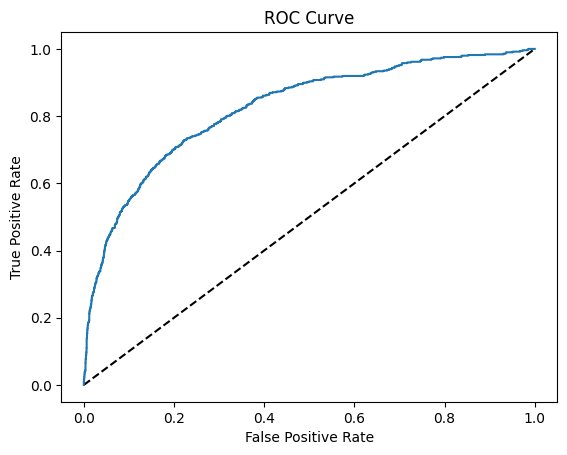

In [127]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(train[TARGET],oof_lgb)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr,tpr,label='LogisticRegression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

7. 提出

In [130]:
# submit_sample.csvを読み込みます。
submit = pd.read_csv("/content/sample_submit.csv", header=None)
submit.head(1)

,0,1
0,3489,0.119451


In [131]:
# テストデータを用いて予測します。
predict0 = models[0].predict(test)
predict1 = models[1].predict(test)
predict2 = models[2].predict(test)
predict = (predict0 + predict1 + predict2) / 3
submit[1] = predict

In [132]:
# 提出
submit.to_csv("submission.csv", index=False, header=None)